# PROJECT - ANALYSIS OF THE TEXAS PRISON SYSTEM

### IMPORTING DEPENDENCIES

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import scipy.stats as st
from datetime import datetime
import gmaps
import os

In [2]:
# Importing data from starter csv file path to create dataframe and showing top 5 rows
prisoner_df = pd.read_csv('./Resources/Texas_Prison_Data_1.csv') 
prisoner_df.head()

,SID Number,TDCJ Number,Name,Current Facility,Gender,Race,Age,Projected Release,Maximum Sentence Date,Parole Eligibility Date,Case Number,County,Offense Code,TDCJ Offense,Sentence Date,Offense Date,Sentence (Years),Last Parole Decision,Next Parole Review Date,Parole Review Status
0,234378,2174505,"LITTLE,AVA JESSUP",Young,F,W,75,10/01/2020,11/15/2025,09/26/2018,068770,Grayson,35990003,POSS CS 4-200G WID METH,12/14/2017,09/13/2017,8.0,Approved on 07/01/2020,NaN,NOT IN REVIEW PROCESS
1,524524,758486,"HARPER,DAVID JOHN JR",Estelle,M,W,91,01/01/9999,01/01/9999,08/03/2031,95-765-C,McLennan,36010001,INDECENCY WITH A CHILD,08/13/1996,09/15/1995,Life,None,08/03/2031,NOT IN REVIEW PROCESS
2,703267,841623,"RODRIGUEZ,THEODORE",Beto,M,W,82,08/03/2043,08/03/2043,02/01/2021,97-396-C,McLennan,11990003,AGG SEX ASLT,08/05/1998,06/01/1996,45.0,None,02/01/2021,IN PAROLE REVIEW PROCESS
3,708520,256174,"ALONZO,BENITO",Hospital Galveston,M,H,85,01/01/9999,01/01/9999,11/25/1985,49995,Travis,49030000,INTRODUCE DEADLY WPN PENAL INSTI,02/27/1976,06/01/1974,Life,Denied on 12/20/2019,12/2020,IN PAROLE REVIEW PROCESS
4,766785,365547,"BROWN,NARRIES EARL",Jester IV,M,W,84,01/01/9999,01/01/9999,08/24/2003,F83-89728-HI,Dallas,11220000,AGG SEX ABUSE CHILD/U14,08/24/1983,03/15/1983,Life,Denied on 12/05/2016,Unavailable at this time.,NOT IN REVIEW PROCESS


In [3]:
# This df is from the Texas Department of Criminal Justice (TDCJ)
# It has ALL the criminal code assignments - those that are currently being
# used AND those no longer used.  Some individuals have codes assigned that are no
# longer active.  This df has a column (Offense_Category)that can be used as a key 
# to link many different specific, detailed codes (Offense Codes) together.

# Importing file with offence codes and categories for data analysis
offense_df = pd.read_csv('./Resources/offenseCodes_ut8.csv', encoding="utf-8")
offense_df

,Offense Code,Offense_Category,Suggested Bin,Offense,Citation,Statute,L/D
0,3990001,100,bin_01_human_trafficking,MISREPRESENT CHILD AS FAMILY MEMBER ENTRY PORT,37.082(c),PC,MB
1,9000001,100,NaN,NaN,NaN,NaN,NaN
2,9000002,100,NaN,NaN,NaN,NaN,NaN
3,9000003,100,NaN,NaN,NaN,NaN,NaN
4,9000005,100,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2733,73991099,6100,bin_61_business_license_permitting,ACTING AS AGENT AFTER LICENSE SUSPEND/REVOKED,4005.151(b),IC,F3
2734,73991100,6100,bin_61_business_license_permitting,AGENT ASSISTING PERSON WITH SUSP/REV LICENSE,4005.152(b),IC,M*
2735,73991101,6100,bin_61_business_license_permitting,VIOLATION OF INSURANCE ADJUSTERS PROVISIONS,4101.203(b),IC,M*
2736,73991102,6100,bin_61_business_license_permitting,VIOLATION OF PUB INSURANCE ADJUSTER PROVISIONS,4102.206(b),IC,MB


### BEGINNING DATA CLEANUP

In [4]:
# Create project specific dataframe with isolated columns for merging. This step creates a smaller dataframe that will be used to merge 
# with the prisoner df on the key offense cateogry and showing top 5 rows.
offproject_df = offense_df.loc[:,["Offense Code", "Offense_Category"]]
offproject_df.head()

,Offense Code,Offense_Category
0,3990001,100
1,9000001,100
2,9000002,100
3,9000003,100
4,9000005,100


In [5]:
# This step actually creates the "bins" - the last column "Offense_Category" can be sorted on
# and capture the respective individuals by offense type.  The "ffill" will place a Nan in 
# the "Offense_Category" column if there is no value in that location.  
# The "merge_ordered" maintains the integrity of the elements in the order of the main df,
# prisoner_df, while matching the Offense_Cateogry" with the respective "Offense Code".
# The prisoner df has approximately 208K rows with many duplicated Offense Code.  
# The offproject df has 2,738 rows of 62 unique Offense Cateogries and related Offense Codes
# which results in the 2,738 rows on information in the df.  The Offense Code column is mapped
# to the respective value in the prisoner df and Offense_Category is assigned to the respective row.

binlookup_df = pd.merge_ordered(prisoner_df, offproject_df, fill_method='ffill', left_by='Offense Code')
binlookup_df.head()

,SID Number,TDCJ Number,Name,Current Facility,Gender,Race,Age,Projected Release,Maximum Sentence Date,Parole Eligibility Date,...,County,Offense Code,TDCJ Offense,Sentence Date,Offense Date,Sentence (Years),Last Parole Decision,Next Parole Review Date,Parole Review Status,Offense_Category
0,234378,2174505,"LITTLE,AVA JESSUP",Young,F,W,75,10/01/2020,11/15/2025,09/26/2018,...,Grayson,35990003,POSS CS 4-200G WID METH,12/14/2017,09/13/2017,8.0,Approved on 07/01/2020,NaN,NOT IN REVIEW PROCESS,2200
1,1116232,1366652,"SIDLE,JOHN ARTHUR",Pack,M,W,78,05/02/2021,06/18/2033,03/08/2016,...,Dallas,35990003,UNLAW POSS WIT C/S-METHAM,04/06/2006,09/03/2004,25.0,Approved on 09/17/2020,NaN,NOT IN REVIEW PROCESS,2200
2,1409034,729430,"LERMA,GILBERT LOPEZ",Wynne,M,H,70,01/01/9999,01/01/9999,08/22/2020,...,Williamson,35990003,DEL C/S,09/19/1995,09/28/1994,Life,Denied on 07/16/2020,07/2021,NOT IN REVIEW PROCESS,2200
3,1468825,2205051,"EVANS,DAYTON BUD",Pack,M,W,70,04/21/2028,03/11/2043,10/20/2020,...,Grayson,35990003,POSS CONT SUB PG1 4-200 WITD,03/12/2018,03/31/2017,25.0,Denied on 08/13/2020,08/2021,NOT IN REVIEW PROCESS,2200
4,1473183,2038325,"GREEN,ROGER DALE SR",Duncan,M,W,73,08/16/2025,06/27/2040,02/14/2018,...,Johnson,35990003,DEL CONT SUB 4G-200G,11/10/2015,05/05/2015,25.0,Denied on 02/06/2020,02/2021,NOT IN REVIEW PROCESS,2200


In [6]:
# Identifying all the Not A Number (NaN) cells in the merged dataframe and making sure our columns of interest have no NaNs
binlookup_df.isna().sum()

SID Number                     0
TDCJ Number                    0
Name                           0
Current Facility               0
Gender                         0
Race                           0
Age                            0
Projected Release              0
Maximum Sentence Date         28
Parole Eligibility Date     9017
Case Number                   99
County                         0
Offense Code                   0
TDCJ Offense                   0
Sentence Date               1233
Offense Date                   0
Sentence (Years)               1
Last Parole Decision        7815
Next Parole Review Date    22397
Parole Review Status        7815
Offense_Category               0
dtype: int64

In [7]:
#Created this to keep from corrupting the good file
#did not need to do this - did not want issues a 2:37am
backup_df = binlookup_df.copy()

In [8]:
#This identifies the unique Offense Category in the prisoner (newly created binlookup)
# df.  There are a total of 62 offense catories overall and 45 were matched to the prisoners
# in the prisoner df when creating the merged_ordered df.

binlookup_df["Offense_Category"].unique()

array([2200,  400, 3200,  200,  500, 4200,  600, 1500, 3700, 1900,  900,
       1600, 1800, 3500, 2300,  300, 6200, 4600, 4500,  700, 3400, 3100,
       4900, 3600, 1200, 2400, 2900, 2700,  100, 4100, 2100, 2600, 4300,
       3300, 3900, 1100, 2500, 6100, 5300, 1400, 5200, 4700, 5500, 5400],
      dtype=int64)

In [9]:
# Create bins in which to place values based upon Offense Categories
# The step serves the purpose of assigning a label to the respective offense category
# must have 1 extra bin then actual catorgies - hence the 0 at the beginning

bins = [0, 100, 200, 300, 400, 500, 600, 700, 900, 1100, 1200, 1400, 
        1500, 1600, 1800, 1900, 2100, 2200, 2300, 2400, 2500, 2600, 
        2700, 2900, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3900, 
        4100, 4200, 4300, 4400, 4500, 4600, 4700, 4900, 5200, 5300, 
        5400, 5500, 6100, 6200]

# Create labels for these bins
group_labels = ["Human_Trafficking", "Murder", "Kidnapping", "Sexual_Assault", "Robbery", "Assault",
                "Coercion_Politics", "Harrassment", "Terrorism", "Arson", "Unlawful_Use", "Burglary", "Theft",
                "Unlawful_Rep", "Fraud_Forgery", "Vandalism", "Drugs", "Sexual_Related_Materials", "Child_Endanger", "Bigamy",
                "Elderly_at_Risk_Adult_Endanger", "Violate_Order", "Prostitution", "Evading_Arrest", "Criminal_Escape",
                "Perjury_Contemp", "Jump_Bail_No_Show", "Interference_Records", "Bribery", "Weapon_Related", 
                "Riot_Obstruction", "Vehicle_Incident", "Alcohol_Incident", "Animal_Related", "Agriculture_Related",
                "Health_Code", "Hazardous_Material", "Discrimination_Civil_Rights", "Record_Tampering", "Tax_Evasion",
                "Pollution", "Money_Laundering", "Negligence", "Business_License", "Organized_Crime"]

In [10]:
# Place the data series (offense category label) into a new (last) column inside of the DataFrame

binlookup_df["Bin_Cat"] = pd.cut(binlookup_df["Offense_Category"], bins, labels=group_labels)
binlookup_df.head()

,SID Number,TDCJ Number,Name,Current Facility,Gender,Race,Age,Projected Release,Maximum Sentence Date,Parole Eligibility Date,...,Offense Code,TDCJ Offense,Sentence Date,Offense Date,Sentence (Years),Last Parole Decision,Next Parole Review Date,Parole Review Status,Offense_Category,Bin_Cat
0,234378,2174505,"LITTLE,AVA JESSUP",Young,F,W,75,10/01/2020,11/15/2025,09/26/2018,...,35990003,POSS CS 4-200G WID METH,12/14/2017,09/13/2017,8.0,Approved on 07/01/2020,NaN,NOT IN REVIEW PROCESS,2200,Drugs
1,1116232,1366652,"SIDLE,JOHN ARTHUR",Pack,M,W,78,05/02/2021,06/18/2033,03/08/2016,...,35990003,UNLAW POSS WIT C/S-METHAM,04/06/2006,09/03/2004,25.0,Approved on 09/17/2020,NaN,NOT IN REVIEW PROCESS,2200,Drugs
2,1409034,729430,"LERMA,GILBERT LOPEZ",Wynne,M,H,70,01/01/9999,01/01/9999,08/22/2020,...,35990003,DEL C/S,09/19/1995,09/28/1994,Life,Denied on 07/16/2020,07/2021,NOT IN REVIEW PROCESS,2200,Drugs
3,1468825,2205051,"EVANS,DAYTON BUD",Pack,M,W,70,04/21/2028,03/11/2043,10/20/2020,...,35990003,POSS CONT SUB PG1 4-200 WITD,03/12/2018,03/31/2017,25.0,Denied on 08/13/2020,08/2021,NOT IN REVIEW PROCESS,2200,Drugs
4,1473183,2038325,"GREEN,ROGER DALE SR",Duncan,M,W,73,08/16/2025,06/27/2040,02/14/2018,...,35990003,DEL CONT SUB 4G-200G,11/10/2015,05/05/2015,25.0,Denied on 02/06/2020,02/2021,NOT IN REVIEW PROCESS,2200,Drugs


In [11]:
# Renaming key columns in our dataframe and assigning to a new variable name
rcbinlookup_df = binlookup_df.rename(columns={"SID Number": "SID_Number", 
                            "TDCJ Number": "TDCJ_Number",
                            "Current Facility" : "Current_Facility",
                            "Projected Release" : "Projected_Release",
                            "Maximum Sentence Date" : "Max_Sentence_Date",
                            "Parole Eligibility Date" : "Parole_Eligible_Date",
                            "Case Number" : "Case_Number",
                            "Offense Code" :"Offense_Code",
                            "TDCJ Offense" :"TDCJ_Offence",
                            "Sentence Date" : "Sentence_Date",
                            "Offense Date": "Offense_Date",
                            "Sentence (Years)" : "Sentence_Years",
                            "Last Parole Decision" : "Last_Parole_Decision",
                            "Next Parole Review Date" : "Next_Parole_Review",
                            "Parole Review Status" : "Parole_Review_Status"})

In [12]:
# Identifying unique year entries in the dataframe to see unique contents
rcbinlookup_df["Sentence_Years"].unique()

array(['8.0', '25.0', 'Life', '12.0', '17.0', '15.0', '10.0', '18.0',
       '65.0', '22.0', '30.0', '35.0', '40.0', '60.0', '5.0', '9.0',
       '50.0', '16.0', '20.0', '3.0', '7.0', '23.0', '75.0', '70.0',
       '99.0', '14.0', '6.0', '45.0', '54.0', '13.0', '26.0', '28.0',
       '19.0', '24.0', '85.0', '33.0', '27.0', '49.0', '11.0', '29.0',
       '32.0', '55.0', '80.0', '9.5', '21.0', '13.5', '68.0', '90.0',
       '48.0', '78.0', '8.5', '37.0', '95.0', '4.0', '42.0', '43.0',
       '56.0', '38.0', '36.0', '12.5', '47.0', '2.0', '15.5', '77.0',
       '44.0', '.7', '10.5', 'LWOP', '61.0', '2.5', '3.3', '12.6', '6.5',
       '3.5', '10.1', '1.5', '52.0', '7.5', '41.0', '52.5', '57.0',
       '31.0', '72.0', '53.0', '22.5', '17.5', '32.5', '62.0', '17.6',
       '130.0', '39.0', 'Capital Life', '198.0', '51.0', '119.0',
       '3000.0', '1000.0', '159.0', '98.0', '102.0', '114.0', '50.5',
       '58.0', '106.0', '46.0', '297.0', '67.0', '66.0', '104.0', '88.0',
       '69.0', '161

In [13]:
# Making a check of data types in the processed dataframe
rcbinlookup_df.dtypes

SID_Number                 int64
TDCJ_Number                int64
Name                      object
Current_Facility          object
Gender                    object
Race                      object
Age                        int64
Projected_Release         object
Max_Sentence_Date         object
Parole_Eligible_Date      object
Case_Number               object
County                    object
Offense_Code               int64
TDCJ_Offence              object
Sentence_Date             object
Offense_Date              object
Sentence_Years            object
Last_Parole_Decision      object
Next_Parole_Review        object
Parole_Review_Status      object
Offense_Category           int64
Bin_Cat                 category
dtype: object

In [14]:
# Replacing certain string entries with numbers in view of data uniformity
rcbinlookup_df=rcbinlookup_df.replace(to_replace="Life",value="50.9")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="LWOP", value="100.9")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="Capital Life", value = "101.9") 
rcbinlookup_df=rcbinlookup_df.replace(to_replace="Death", value = "150.9")

# Outputting top 5 rows of dataframe

rcbinlookup_df.head()

,SID_Number,TDCJ_Number,Name,Current_Facility,Gender,Race,Age,Projected_Release,Max_Sentence_Date,Parole_Eligible_Date,...,Offense_Code,TDCJ_Offence,Sentence_Date,Offense_Date,Sentence_Years,Last_Parole_Decision,Next_Parole_Review,Parole_Review_Status,Offense_Category,Bin_Cat
0,234378,2174505,"LITTLE,AVA JESSUP",Young,F,W,75,10/01/2020,11/15/2025,09/26/2018,...,35990003,POSS CS 4-200G WID METH,12/14/2017,09/13/2017,8.0,Approved on 07/01/2020,NaN,NOT IN REVIEW PROCESS,2200,Drugs
1,1116232,1366652,"SIDLE,JOHN ARTHUR",Pack,M,W,78,05/02/2021,06/18/2033,03/08/2016,...,35990003,UNLAW POSS WIT C/S-METHAM,04/06/2006,09/03/2004,25.0,Approved on 09/17/2020,NaN,NOT IN REVIEW PROCESS,2200,Drugs
2,1409034,729430,"LERMA,GILBERT LOPEZ",Wynne,M,H,70,01/01/9999,01/01/9999,08/22/2020,...,35990003,DEL C/S,09/19/1995,09/28/1994,50.9,Denied on 07/16/2020,07/2021,NOT IN REVIEW PROCESS,2200,Drugs
3,1468825,2205051,"EVANS,DAYTON BUD",Pack,M,W,70,04/21/2028,03/11/2043,10/20/2020,...,35990003,POSS CONT SUB PG1 4-200 WITD,03/12/2018,03/31/2017,25.0,Denied on 08/13/2020,08/2021,NOT IN REVIEW PROCESS,2200,Drugs
4,1473183,2038325,"GREEN,ROGER DALE SR",Duncan,M,W,73,08/16/2025,06/27/2040,02/14/2018,...,35990003,DEL CONT SUB 4G-200G,11/10/2015,05/05/2015,25.0,Denied on 02/06/2020,02/2021,NOT IN REVIEW PROCESS,2200,Drugs


In [15]:
# Conducting check of unique data in the 'Sentence_Years' column
rcbinlookup_df["Sentence_Years"].unique()

array(['8.0', '25.0', '50.9', '12.0', '17.0', '15.0', '10.0', '18.0',
       '65.0', '22.0', '30.0', '35.0', '40.0', '60.0', '5.0', '9.0',
       '50.0', '16.0', '20.0', '3.0', '7.0', '23.0', '75.0', '70.0',
       '99.0', '14.0', '6.0', '45.0', '54.0', '13.0', '26.0', '28.0',
       '19.0', '24.0', '85.0', '33.0', '27.0', '49.0', '11.0', '29.0',
       '32.0', '55.0', '80.0', '9.5', '21.0', '13.5', '68.0', '90.0',
       '48.0', '78.0', '8.5', '37.0', '95.0', '4.0', '42.0', '43.0',
       '56.0', '38.0', '36.0', '12.5', '47.0', '2.0', '15.5', '77.0',
       '44.0', '.7', '10.5', '100.9', '61.0', '2.5', '3.3', '12.6', '6.5',
       '3.5', '10.1', '1.5', '52.0', '7.5', '41.0', '52.5', '57.0',
       '31.0', '72.0', '53.0', '22.5', '17.5', '32.5', '62.0', '17.6',
       '130.0', '39.0', '101.9', '198.0', '51.0', '119.0', '3000.0',
       '1000.0', '159.0', '98.0', '102.0', '114.0', '50.5', '58.0',
       '106.0', '46.0', '297.0', '67.0', '66.0', '104.0', '88.0', '69.0',
       '161.0', '

In [16]:
# Replacing certain wrong entries with year span values calculated from imported data
# these are global changes - so need to check at some point for data in other columns being inadvertently changed
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2024.9",value="6.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2092.7", value="8.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2027.0", value = "10.0") 
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2026.4", value = "11.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2027.1",  value = "10.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2024.8",value="6.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2024.7", value="7.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2023.5", value = "5.0") 
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2026.3", value = "8.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2020.8",  value = "5.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2022.4",value="8.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2019.8", value="10.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2022.2", value = "5.0") 
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2024.0", value = "6.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2029.9",  value = "10.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2022.3",value="6.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2027.9", value="8.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2023.4", value = "6.0") 
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2021.4", value = "6.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2021.5",value="2.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2022.9", value="3.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2022.8", value = "4.0") 
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2023.0", value = "5.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2024.3",  value = "6.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2021.6",value="4.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2021.2", value="5.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2022.7", value = "5.0") 
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2023.9", value = "4.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2025.1",  value = "9.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2020.5",value="1.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2019.5", value="4.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2029.5", value = "10.0") 
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2021.9", value = "10.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2025.0",  value = "6.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2024.5",value="5.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2022.6", value="3.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2020.2", value = "2.0") 
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2030.0", value = "11.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2023.6",  value = "5.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2024.2",value="6.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2029.7",  value = "8.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2020.9",value="2.0")

In [17]:
# Making a check of our 'Sentence_Years' column to see what unique entries need cleanup
rcbinlookup_df["Sentence_Years"].unique()

array(['8.0', '25.0', '50.9', '12.0', '17.0', '15.0', '10.0', '18.0',
       '65.0', '22.0', '30.0', '35.0', '40.0', '60.0', '5.0', '9.0',
       '50.0', '16.0', '20.0', '3.0', '7.0', '23.0', '75.0', '70.0',
       '99.0', '14.0', '6.0', '45.0', '54.0', '13.0', '26.0', '28.0',
       '19.0', '24.0', '85.0', '33.0', '27.0', '49.0', '11.0', '29.0',
       '32.0', '55.0', '80.0', '9.5', '21.0', '13.5', '68.0', '90.0',
       '48.0', '78.0', '8.5', '37.0', '95.0', '4.0', '42.0', '43.0',
       '56.0', '38.0', '36.0', '12.5', '47.0', '2.0', '15.5', '77.0',
       '44.0', '.7', '10.5', '100.9', '61.0', '2.5', '3.3', '12.6', '6.5',
       '3.5', '10.1', '1.5', '52.0', '7.5', '41.0', '52.5', '57.0',
       '31.0', '72.0', '53.0', '22.5', '17.5', '32.5', '62.0', '17.6',
       '130.0', '39.0', '101.9', '198.0', '51.0', '119.0', '3000.0',
       '1000.0', '159.0', '98.0', '102.0', '114.0', '50.5', '58.0',
       '106.0', '46.0', '297.0', '67.0', '66.0', '104.0', '88.0', '69.0',
       '161.0', '

In [18]:
# Checking for the row with sentence year equal to 800 so we can check the data entries for the specific row
rcbinlookup_df.loc[rcbinlookup_df["Sentence_Years"] == "800.0"]

,SID_Number,TDCJ_Number,Name,Current_Facility,Gender,Race,Age,Projected_Release,Max_Sentence_Date,Parole_Eligible_Date,...,Offense_Code,TDCJ_Offence,Sentence_Date,Offense_Date,Sentence_Years,Last_Parole_Decision,Next_Parole_Review,Parole_Review_Status,Offense_Category,Bin_Cat
90279,1436401,219085,"HEMPHILL,SAMUEL",Wynne,M,B,69,03/02/2309,01/19/2779,10/02/2030,...,11020000,RAPE,04/13/1970,10/30/1969,800.0,None,10/02/2030,NOT IN REVIEW PROCESS,400,Sexual_Assault


In [19]:
# Assigning value to NaN to location.  Other sentence lengths in bin were taken into account
# when assigning number

rcbinlookup_df.loc[71997,"Sentence_Years"] = 10.0
# rcbinlookup_df["Sentence_Years"].unique()

In [20]:
# Create age bins for categorizing age brackets
# must have 1 extra bin then actual catorgies - hence the 0 at the beginning

agebins = [0, 19.9, 29.9, 39.9, 49.9, 59.9, 69.9, 79.9, 89.9, 99.9, 199.9]

# Create labels for these bins associated with the prisoners ages
agegroup_labels = ["<20", "20-30", "31-40",
                   "41-50", "51-60", "61-70",
                   "71-80", "81-90", "91-100", "100+"]   

In [21]:
# Create new column - Age_Bin in our dataframe

rcbinlookup_df["Age_Bin"] = pd.cut(rcbinlookup_df["Age"], agebins, labels=agegroup_labels)
rcbinlookup_df

,SID_Number,TDCJ_Number,Name,Current_Facility,Gender,Race,Age,Projected_Release,Max_Sentence_Date,Parole_Eligible_Date,...,TDCJ_Offence,Sentence_Date,Offense_Date,Sentence_Years,Last_Parole_Decision,Next_Parole_Review,Parole_Review_Status,Offense_Category,Bin_Cat,Age_Bin
0,234378,2174505,"LITTLE,AVA JESSUP",Young,F,W,75,10/01/2020,11/15/2025,09/26/2018,...,POSS CS 4-200G WID METH,12/14/2017,09/13/2017,8.0,Approved on 07/01/2020,NaN,NOT IN REVIEW PROCESS,2200,Drugs,71-80
1,1116232,1366652,"SIDLE,JOHN ARTHUR",Pack,M,W,78,05/02/2021,06/18/2033,03/08/2016,...,UNLAW POSS WIT C/S-METHAM,04/06/2006,09/03/2004,25.0,Approved on 09/17/2020,NaN,NOT IN REVIEW PROCESS,2200,Drugs,71-80
2,1409034,729430,"LERMA,GILBERT LOPEZ",Wynne,M,H,70,01/01/9999,01/01/9999,08/22/2020,...,DEL C/S,09/19/1995,09/28/1994,50.9,Denied on 07/16/2020,07/2021,NOT IN REVIEW PROCESS,2200,Drugs,71-80
3,1468825,2205051,"EVANS,DAYTON BUD",Pack,M,W,70,04/21/2028,03/11/2043,10/20/2020,...,POSS CONT SUB PG1 4-200 WITD,03/12/2018,03/31/2017,25.0,Denied on 08/13/2020,08/2021,NOT IN REVIEW PROCESS,2200,Drugs,71-80
4,1473183,2038325,"GREEN,ROGER DALE SR",Duncan,M,W,73,08/16/2025,06/27/2040,02/14/2018,...,DEL CONT SUB 4G-200G,11/10/2015,05/05/2015,25.0,Denied on 02/06/2020,02/2021,NOT IN REVIEW PROCESS,2200,Drugs,71-80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120702,50538037,2250200,"DAVIS,ZAKAYLA MONAENYCOLE",Hilltop,F,B,20,06/22/2023,06/22/2023,06/21/2020,...,TRAFFICK CHILD WI FORCED LABOR,02/18/2019,06/22/2018,5.0,Denied on 05/28/2020,05/2022,NOT IN REVIEW PROCESS,100,Human_Trafficking,20-30
120703,50580998,2087444,"RICKETTS,DUSTIN LEE",Connally,M,W,24,12/09/2022,10/05/2023,04/02/2017,...,UNL USE OF CRIMINAL INTS,02/04/2016,10/07/2014,8.0,Denied on 02/07/2017,Unavailable at this time.,NOT IN REVIEW PROCESS,1400,Unlawful_Use,20-30
120704,50709066,2144543,"WERKMEISTER,DEBORAH JANE",Hilltop,F,W,55,11/01/2020,06/22/2027,07/23/2018,...,THEFT BY PUBLIC SERVANT,06/23/2017,05/01/2009,10.0,Approved on 06/12/2020,NaN,NOT IN REVIEW PROCESS,1600,Theft,51-60
120705,50776498,2298374,"NINO-RUIZ,JOSE EDUARDO",Lychner,M,H,29,12/05/2021,12/05/2021,NaN,...,BESTIALITY,12/09/2019,03/15/2019,2.0,NaN,NaN,NaN,400,Sexual_Assault,20-30


### BEGINNING CLEANUP FOR COUNTIES

In [22]:
# starting cleanup on Data Column for Counties 
# file sent to CSV for easier review

rc_un = rcbinlookup_df['County'].unique()
rc_un = np.sort(rc_un)
rc_un = pd.DataFrame(rc_un)
rc_un.to_csv('./Resources/rc_counties.csv', index=False)

In [23]:
# Replace Lasalle with La Salle

rcbinlookup_df = rcbinlookup_df.replace(to_replace="Lasalle", value= "La Salle")
rcbinlookup_df

,SID_Number,TDCJ_Number,Name,Current_Facility,Gender,Race,Age,Projected_Release,Max_Sentence_Date,Parole_Eligible_Date,...,TDCJ_Offence,Sentence_Date,Offense_Date,Sentence_Years,Last_Parole_Decision,Next_Parole_Review,Parole_Review_Status,Offense_Category,Bin_Cat,Age_Bin
0,234378,2174505,"LITTLE,AVA JESSUP",Young,F,W,75,10/01/2020,11/15/2025,09/26/2018,...,POSS CS 4-200G WID METH,12/14/2017,09/13/2017,8.0,Approved on 07/01/2020,NaN,NOT IN REVIEW PROCESS,2200,Drugs,71-80
1,1116232,1366652,"SIDLE,JOHN ARTHUR",Pack,M,W,78,05/02/2021,06/18/2033,03/08/2016,...,UNLAW POSS WIT C/S-METHAM,04/06/2006,09/03/2004,25.0,Approved on 09/17/2020,NaN,NOT IN REVIEW PROCESS,2200,Drugs,71-80
2,1409034,729430,"LERMA,GILBERT LOPEZ",Wynne,M,H,70,01/01/9999,01/01/9999,08/22/2020,...,DEL C/S,09/19/1995,09/28/1994,50.9,Denied on 07/16/2020,07/2021,NOT IN REVIEW PROCESS,2200,Drugs,71-80
3,1468825,2205051,"EVANS,DAYTON BUD",Pack,M,W,70,04/21/2028,03/11/2043,10/20/2020,...,POSS CONT SUB PG1 4-200 WITD,03/12/2018,03/31/2017,25.0,Denied on 08/13/2020,08/2021,NOT IN REVIEW PROCESS,2200,Drugs,71-80
4,1473183,2038325,"GREEN,ROGER DALE SR",Duncan,M,W,73,08/16/2025,06/27/2040,02/14/2018,...,DEL CONT SUB 4G-200G,11/10/2015,05/05/2015,25.0,Denied on 02/06/2020,02/2021,NOT IN REVIEW PROCESS,2200,Drugs,71-80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120702,50538037,2250200,"DAVIS,ZAKAYLA MONAENYCOLE",Hilltop,F,B,20,06/22/2023,06/22/2023,06/21/2020,...,TRAFFICK CHILD WI FORCED LABOR,02/18/2019,06/22/2018,5.0,Denied on 05/28/2020,05/2022,NOT IN REVIEW PROCESS,100,Human_Trafficking,20-30
120703,50580998,2087444,"RICKETTS,DUSTIN LEE",Connally,M,W,24,12/09/2022,10/05/2023,04/02/2017,...,UNL USE OF CRIMINAL INTS,02/04/2016,10/07/2014,8.0,Denied on 02/07/2017,Unavailable at this time.,NOT IN REVIEW PROCESS,1400,Unlawful_Use,20-30
120704,50709066,2144543,"WERKMEISTER,DEBORAH JANE",Hilltop,F,W,55,11/01/2020,06/22/2027,07/23/2018,...,THEFT BY PUBLIC SERVANT,06/23/2017,05/01/2009,10.0,Approved on 06/12/2020,NaN,NOT IN REVIEW PROCESS,1600,Theft,51-60
120705,50776498,2298374,"NINO-RUIZ,JOSE EDUARDO",Lychner,M,H,29,12/05/2021,12/05/2021,NaN,...,BESTIALITY,12/09/2019,03/15/2019,2.0,NaN,NaN,NaN,400,Sexual_Assault,20-30


In [24]:
# Loading and manipulating population data for 2020 pop data
# the original data file was from state of Texas site and had out year projections
# needed to extract year 2020 values

countyall_df = pd.read_csv('./Resources/pop_data_with_projection.csv')
texas2020_df = countyall_df.query('year == 2020')
county2020_df = texas2020_df.loc[texas2020_df['age_group'] == "ALL"]
notex_df = county2020_df.drop([60])
proj_county2020 = notex_df.loc[:,["area_name", "total"]]
rcproj_county2020_df = proj_county2020.rename(columns={"area_name": "County", "total" : "Population_2020"})

pd.set_option('display.max_columns', None)
rcproj_county2020_df

C:\Users\jonat\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,County,Population_2020
306,Anderson County,58199
552,Andrews County,22269
798,Angelina County,90437
1044,Aransas County,27699
1290,Archer County,8344
...,...,...
124292,Wood County,45292
124538,Yoakum County,9225
124784,Young County,18712
125030,Zapata County,14409


In [25]:
# Merge Prison and Population database for a specific analysis of the population data for heat map generation
mother_ship_df = pd.merge_ordered(rcbinlookup_df, rcproj_county2020_df, fill_method='ffill', left_by='County')
mother_ship_df.isna().sum()

# found NaN that need to be corrected
# looked up county pop and corrected

values = {"Population_2020": 21737}
mother_ship_df.fillna(value=values)

# Outputting the new dataframe for generic use by all TEAM 4 members
mother_ship_df

,SID_Number,TDCJ_Number,Name,Current_Facility,Gender,Race,Age,Projected_Release,Max_Sentence_Date,Parole_Eligible_Date,Case_Number,County,Offense_Code,TDCJ_Offence,Sentence_Date,Offense_Date,Sentence_Years,Last_Parole_Decision,Next_Parole_Review,Parole_Review_Status,Offense_Category,Bin_Cat,Age_Bin,Population_2020
0,234378,2174505,"LITTLE,AVA JESSUP",Young,F,W,75,10/01/2020,11/15/2025,09/26/2018,068770,Grayson,35990003,POSS CS 4-200G WID METH,12/14/2017,09/13/2017,8.0,Approved on 07/01/2020,NaN,NOT IN REVIEW PROCESS,2200,Drugs,71-80,NaN
1,1468825,2205051,"EVANS,DAYTON BUD",Pack,M,W,70,04/21/2028,03/11/2043,10/20/2020,068250,Grayson,35990003,POSS CONT SUB PG1 4-200 WITD,03/12/2018,03/31/2017,25.0,Denied on 08/13/2020,08/2021,NOT IN REVIEW PROCESS,2200,Drugs,71-80,NaN
2,1505838,2119905,"PENNINGTON,RICKEY DWAYNE",Pack,M,W,68,12/21/2028,12/21/2028,04/11/2018,067845,Grayson,35990003,POSS CS WITD-METH 4-200G,02/08/2017,12/21/2016,12.0,Denied on 01/02/2020,12/2020,IN PAROLE REVIEW PROCESS,2200,Drugs,61-70,NaN
3,2141308,2153019,"JACOBS,ANTHONY",Ellis,M,W,64,12/18/2023,06/14/2033,02/28/2019,068249,Grayson,35990003,POSS CS 4-200G WID METH,07/27/2017,10/11/2016,16.0,Denied on 02/19/2020,02/2021,NOT IN REVIEW PROCESS,2200,Drugs,61-70,NaN
4,2360914,2290868,"WALDEN,LONNIE WAYNE",Gurney,M,W,62,04/02/2033,05/28/2049,NaN,071105,Grayson,35990003,MAN DEL CS PG1 4-200G METH,10/24/2019,05/29/2019,30.0,None,Unavailable at this time.,NOT IN REVIEW PROCESS,2200,Drugs,61-70,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120702,5826119,2251746,"MUNOZ,JOSE JR",Polunsky,M,H,40,04/26/2022,07/24/2026,08/19/2019,M-19-0011-CR-B,McMullen,48990012,TAMPERING W/A WITNESS,02/04/2019,07/24/2018,8.0,Denied on 07/07/2020,07/2021,NOT IN REVIEW PROCESS,3100,Evading_Arrest,41-50,NaN
120703,4231127,2043573,"BRAVO,CARLOS RUIZ",Wynne,M,H,61,06/30/2033,04/25/2060,12/31/2019,M-13-0007-CR-B,McMullen,35620013,POSS MARIJUANA M/2000LBS,12/02/2015,10/19/2012,45.0,Denied on 12/09/2019,12/2020,IN PAROLE REVIEW PROCESS,2200,Drugs,61-70,NaN
120704,7987519,2284322,"MORRIS,JUSTIN LEE",Dominguez,M,W,31,05/30/2021,05/30/2021,NaN,M-19-0010-CR-B,McMullen,23990008,(LIO) THEFT OF FIREARM,07/08/2019,07/21/2017,2.0,NaN,NaN,NaN,1600,Theft,31-40,NaN
120705,7273574,2311921,"GONZALEZ,MIGUEL",Willacy County,M,H,30,07/12/2022,02/09/2027,01/13/2020,M-17-0006-CR-B,McMullen,64110001,SMUGGLING OF PERSONS,01/31/2020,06/04/2016,8.0,Denied on 06/24/2020,06/2021,NOT IN REVIEW PROCESS,100,Human_Trafficking,31-40,NaN


## BEGINNING ANALYSIS FOR AGE, COUNTY, GENDER AND POPULATION RATIO ANALYSIS

In [26]:
# Creating new base dataframe for subject analysis by isolating columns of interest, renaming Bin_Cat column and
# outputting top 5 rows.
jemothership_df = mother_ship_df[['SID_Number','TDCJ_Number','Name', 'Gender','Race', 'Age','Case_Number', 'County','Offense_Code','Offense_Category','Bin_Cat','Age_Bin']]
jemothership_df = jemothership_df.rename(columns={'Bin_Cat': 'Offences'})
jemothership_df.head()

,SID_Number,TDCJ_Number,Name,Gender,Race,Age,Case_Number,County,Offense_Code,Offense_Category,Offences,Age_Bin
0,234378,2174505,"LITTLE,AVA JESSUP",F,W,75,068770,Grayson,35990003,2200,Drugs,71-80
1,1468825,2205051,"EVANS,DAYTON BUD",M,W,70,068250,Grayson,35990003,2200,Drugs,71-80
2,1505838,2119905,"PENNINGTON,RICKEY DWAYNE",M,W,68,067845,Grayson,35990003,2200,Drugs,61-70
3,2141308,2153019,"JACOBS,ANTHONY",M,W,64,068249,Grayson,35990003,2200,Drugs,61-70
4,2360914,2290868,"WALDEN,LONNIE WAYNE",M,W,62,071105,Grayson,35990003,2200,Drugs,61-70


In [27]:
# Selecting 3 columns from base dataframe for crime by age bracket analysis and displaying dataframe
agebin_bincat_df = jemothership_df[['Age_Bin', 'Offences', 'County']]
agebin_bincat_df

,Age_Bin,Offences,County
0,71-80,Drugs,Grayson
1,71-80,Drugs,Grayson
2,61-70,Drugs,Grayson
3,61-70,Drugs,Grayson
4,61-70,Drugs,Grayson
...,...,...,...
120702,41-50,Evading_Arrest,McMullen
120703,61-70,Drugs,McMullen
120704,31-40,Theft,McMullen
120705,31-40,Human_Trafficking,McMullen


### IDENTIFYING BASIS FOR ANALYSIS, WILL FOCUS ON TOP TEN COUNTIES AND OFFENCES

In [28]:
# Identifying our top 20 counties with most prisoner population and selecting top 10 for analysis 
jemothership_df['County'].value_counts().head(10)

Harris        17483
Dallas        11654
Tarrant        8365
Bexar          8308
Travis         3086
McLennan       2577
Smith          2390
Hidalgo        2273
Montgomery     2136
El Paso        2026
Name: County, dtype: int64

In [29]:
# Identifying our top 20 offences with most prisoner population and selecting top 10 for analysis 
jemothership_df['Offences'].value_counts().head(10)

Sexual_Assault      22052
Assault             17812
Robbery             17630
Drugs               17151
Murder              14937
Burglary             7165
Alcohol_Incident     4874
Evading_Arrest       4149
Weapon_Related       2852
Theft                2216
Name: Offences, dtype: int64

In [30]:
# Creating Top 10 Counties list and Top 10 Offences list for analysis based on established county and offences list above
cnty_list = ['Harris', 'Dallas', 'Tarrant', 'Bexar', 'McLennan', 'Montgomery', 'Travis', 'Smith', 'El Paso', 'Hidalgo']
off_list = ['Sexual_Assault', 'Assault', 'Robbery', 'Drugs', 'Murder', 'Burglary', 'Alcohol_Incident', 'Evading_Arrest', 'Weapon_Related', 'Theft']

### Modifying base dataframe for critical data analysis and visualization

In [31]:
# Renaming Gender column with proper gender designation for easier read or identification
jemothership_df['Gender'] = jemothership_df['Gender'].replace({'M':'Male', 'F':'Female'})

In [32]:
# Creating data series of Age_Bin, County as index and making a count by offences
age_cnty_ser = agebin_bincat_df.groupby(['Age_Bin','County']).Offences.count()

In [33]:
# Creating a dataframe of the previous series data
age_cnty_ser_df = pd.DataFrame(age_cnty_ser)
age_cnty_ser_df

Offences
Age_Bin County            
<20     Anderson         0
        Andrews          0
        Angelina         5
        Aransas          1
        Archer           0
...                    ...
100+    Wood             0
        Yoakum           0
        Young            0
        Zapata           0
        Zavala           0

[2530 rows x 1 columns]

In [34]:
# Making a check of how the offences count spread by age bracket and county as a basis of first look
age_cnty_ser_df.sort_values(by=['Offences'], ascending=False)

Offences
Age_Bin County            
31-40   Harris        4988
20-30   Harris        4095
41-50   Harris        4009
31-40   Dallas        3304
        Bexar         2894
...                    ...
81-90   Colorado         0
        Comal            0
        Comanche         0
        Concho           0
100+    Zavala           0

[2530 rows x 1 columns]

In [35]:
# Reseting index in preparation for visualizing the data in a bar plot
age_cnty_ser_df.reset_index()

,Age_Bin,County,Offences
0,<20,Anderson,0
1,<20,Andrews,0
2,<20,Angelina,5
3,<20,Aransas,1
4,<20,Archer,0
...,...,...,...
2525,100+,Wood,0
2526,100+,Yoakum,0
2527,100+,Young,0
2528,100+,Zapata,0


In [36]:
# Unstacking the dataframe for bar plotting
ag_cnt_unstk_df = age_cnty_ser.unstack()
ag_cnt_unstk_df

County,Anderson,Andrews,Angelina,Aransas,Archer,Armstrong,Atascosa,Austin,Bailey,Bandera,Bastrop,Baylor,Bee,Bell,Bexar,Blanco,Borden,Bosque,Bowie,Brazoria,Brazos,Brewster,Briscoe,Brooks,Brown,Burleson,Burnet,Caldwell,Calhoun,Callahan,Cameron,Camp,Carson,Cass,Castro,Chambers,Cherokee,Childress,Clay,Cochran,Coke,Coleman,Collin,Collingsworth,Colorado,Comal,Comanche,Concho,Cooke,Coryell,Cottle,Crane,Crockett,Crosby,Culberson,Dallam,Dallas,Dawson,Deaf Smith,Delta,Denton,Dewitt,Dickens,Dimmit,Donley,Duval,Eastland,Ector,Edwards,El Paso,Ellis,Erath,Falls,Fannin,Fayette,Fisher,Floyd,Foard,Fort Bend,Franklin,Freestone,Frio,Gaines,Galveston,Garza,Gillespie,Glasscock,Goliad,Gonzales,Gray,Grayson,Gregg,Grimes,Guadalupe,Hale,Hall,Hamilton,Hansford,Hardeman,Hardin,Harris,Harrison,Hartley,Haskell,Hays,Hemphill,Henderson,Hidalgo,Hill,Hockley,Hood,Hopkins,Houston,Howard,Hudspeth,Hunt,Hutchinson,Irion,Jack,Jackson,Jasper,Jeff Davis,Jefferson,Jim Hogg,Jim Wells,Johnson,Jones,Karnes,Kaufman,Kendall,Kenedy,Kent,Kerr,Kimble,Kinney,Kleberg,Knox,La Salle,Lamar,Lamb,Lampasas,Lavaca,Lee,Leon,Liberty,Limestone,Lipscomb,Live Oak,Llano,Loving,Lubbock,Lynn,Madison,Marion,Martin,Mason,Matagorda,Maverick,McCulloch,McLennan,McMullen,Medina,Menard,Midland,Milam,Mills,Mitchell,Montague,Montgomery,Moore,Morris,Motley,Nacogdoches,Navarro,Newton,Nolan,Nueces,Ochiltree,Oldham,Orange,Palo Pinto,Panola,Parker,Parmer,Pecos,Polk,Potter,Presidio,Rains,Randall,Reagan,Real,Red River,Reeves,Refugio,Roberts,Robertson,Rockwall,Runnels,Rusk,Sabine,San Augustine,San Jacinto,San Patricio,San Saba,Schleicher,Scurry,Shackelford,Shelby,Sherman,Smith,Somervell,Starr,Stephens,Sterling,Stonewall,Sutton,Swisher,Tarrant,Taylor,Terrell,Terry,Throckmorton,Titus,Tom Green,Travis,Trinity,Tyler,Upshur,Upton,Uvalde,Val Verde,Van Zandt,Victoria,Walker,Waller,Ward,Washington,Webb,Wharton,Wheeler,Wichita,Wilbarger,Willacy,Williamson,Wilson,Winkler,Wise,Wood,Yoakum,Young,Zapata,Zavala
Age_Bin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
<20,0,0,5,1,0,0,0,0,0,0,0,0,0,19,27,0,0,0,6,11,6,0,0,0,27,0,2,1,0,0,10,0,0,2,0,0,0,0,0,0,0,1,6,0,0,2,0,0,2,2,0,0,0,0,0,0,69,0,1,0,6,0,0,0,0,0,1,9,0,15,1,0,1,2,0,0,0,0,4,0,0,0,3,3,0,0,0,0,0,0,6,7,0,2,1,1,0,0,0,0,80,5,0,0,1,0,4,26,5,0,0,4,0,4,0,0,0,0,0,0,0,0,18,0,0,5,0,0,5,0,0,0,1,1,0,0,0,0,2,0,0,0,4,0,1,1,0,0,1,0,6,0,0,0,0,0,4,0,0,24,0,0,0,10,0,0,0,0,20,0,2,0,0,3,0,2,2,0,0,0,1,0,5,0,0,0,6,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,7,0,0,0,0,0,0,0,62,9,0,0,3,0,2,14,0,0,1,0,0,0,0,5,0,0,0,0,3,1,0,1,0,0,2,0,0,2,0,0,3,0,0
20-30,85,19,121,26,1,0,41,20,12,16,28,2,24,332,1753,10,0,19,178,258,279,5,0,7,155,28,36,34,19,13,325,12,25,38,7,37,59,28,6,2,1,22,333,6,45,141,18,1,47,90,0,3,5,1,0,4,2395,31,66,3,200,25,2,16,6,3,47,315,0,449,163,56,18,39,10,1,8,1,172,11,15,11,12,212,5,26,1,6,59,29,198,225,26,138,26,12,21,3,4,47,4095,70,0,14,121,1,65,609,76,19,81,80,43,59,2,120,22,0,8,48,35,1,391,2,19,179,20,17,104,27,1,0,101,3,2,50,2,10,148,20,17,19,25,22,104,33,1,18,8,0,260,1,21,18,2,0,25,18,13,502,3,38,2,251,30,10,11,13,412,15,15,0,85,74,15,34,306,3,1,107,84,17,130,9,15,63,248,2,6,140,3,0,15,16,3,1,16,90,11,18,10,2,30,82,1,1,37,1,26,2,488,5,17,10,1,0,3,8,1796,296,0,7,0,22,190,626,16,33,54,5,18,40,40,167,50,27,11,49,112,28,5,144,27,13,156,17,7,39,35,3,25,5,2
31-40,156,26,210,40,6,1,68,23,14,26,65,9,76,553,2894,18,0,27,217,380,411,8,0,4,193,57,77,49,34,17,362,9,33,58,13,59,98,29,5,2,1,33,459,14,57,261,38,10,93,131,3,10,11,7,0,6,3304,54,79,8,341,47,2,20,10,22,88,360,4,615,243,75,35,72,24,4,13,0,283,22,32,26,22,370,12,43,1,6,81,51,370,365,38,221,67,11,18,4,13,83,4988,112,5,14,199,0,138,766,109,35,159,110,66,64,5,179,34,1,17,63,59,2,526,1,36,342,24,37,133,56,3,1,200,11,2,77,1,15,170,25,27,25,21,37,178,74,1,21,24,0,505,8,52,44,3,1,66,13,13,837,2,61,6,289,45,17,20,26,610,33,32,2,136

#### This dataframe gives us the Offence counts in top 10 counties by age bracket

In [37]:
# Selecting key columns of interest in our unstacked dataframe based on identified top 10 counties and viewing the dataframe
ag_cnt_unstk_sortd_df = ag_cnt_unstk_df.loc[:,['Harris', 'Dallas', 'Tarrant', 'Bexar', 'McLennan', 'Montgomery', 'Travis', 'Smith', 'El Paso', 'Hidalgo']]
ag_cnt_unstk_sortd_df 

County,Harris,Dallas,Tarrant,Bexar,McLennan,Montgomery,Travis,Smith,El Paso,Hidalgo
Age_Bin,,,,,,,,,,
<20,80,69,62,27,24,20,14,7,15,26
20-30,4095,2395,1796,1753,502,412,626,488,449,609
31-40,4988,3304,2445,2894,837,610,858,722,615,766
41-50,4009,2767,1976,1966,619,544,744,542,517,526
51-60,2786,2032,1381,1124,390,364,540,417,285,244
61-70,1298,899,588,444,167,149,250,175,119,80
71-80,209,168,108,90,33,29,49,37,25,22
81-90,18,20,9,10,4,7,5,2,1,0
91-100,0,0,0,0,1,1,0,0,0,0


#### Retrieving age categories and offences data for top 10 offences by age bracket

In [38]:
# Isolating Age_Bin, Offences and County columns for offences by age bracket analysis and passing to a new dataframe
for_agebrkt_crime = jemothership_df[['Age_Bin', 'Offences', 'County']]
for_agebrkt_crime

,Age_Bin,Offences,County
0,71-80,Drugs,Grayson
1,71-80,Drugs,Grayson
2,61-70,Drugs,Grayson
3,61-70,Drugs,Grayson
4,61-70,Drugs,Grayson
...,...,...,...
120702,41-50,Evading_Arrest,McMullen
120703,61-70,Drugs,McMullen
120704,31-40,Theft,McMullen
120705,31-40,Human_Trafficking,McMullen


##### Top 10 Counties in Texas data retrieval for plots

In [39]:
# Isolating top 10 counties in Texas for counts plot
tx_tp10_cnty = for_agebrkt_crime['County'].value_counts()
pd.DataFrame(tx_tp10_cnty.head(10))

,County
Harris,17483
Dallas,11654
Tarrant,8365
Bexar,8308
Travis,3086
McLennan,2577
Smith,2390
Hidalgo,2273
Montgomery,2136
El Paso,2026


In [40]:
# Setting up Top 10 Counties for visualization bar plot
qcklk_cnty_cnt = pd.DataFrame(tx_tp10_cnty.head(10))

##### Top 10 Offences in Texas data retrieval for plots

In [41]:
# Isolating top 10 offences in Texas for counts plot
gpby_for_agebrkt_crime = for_agebrkt_crime['Offences'].value_counts()
pd.DataFrame(gpby_for_agebrkt_crime.head(10))

,Offences
Sexual_Assault,22052
Assault,17812
Robbery,17630
Drugs,17151
Murder,14937
Burglary,7165
Alcohol_Incident,4874
Evading_Arrest,4149
Weapon_Related,2852
Theft,2216


In [42]:
# Setting up Top 10 Offences for visualization bar plot
qcklk_crime_cnt = pd.DataFrame(gpby_for_agebrkt_crime.head(10))

##### Top 10 Offences in Texas by age categories data retrieval for plots

In [43]:
# Grouping base dataframe by Age Category (Age_Bin) for Offences count per age group
check_alt_df = jemothership_df.groupby('Age_Bin')['Offences'].count()
pd.DataFrame(check_alt_df)

,Offences
Age_Bin,
<20,634
20-30,24763
31-40,36784
41-50,28833
51-60,19556
61-70,8345
71-80,1626
81-90,164
91-100,2


In [44]:
# Setting up Top 10 Offences by age ranges for visualization bar plot
qcklk_cnty_cnt = pd.DataFrame(check_alt_df)

In [45]:
# Grouping age brackets and offences by Top 10 Counties
age_bincat_ser = agebin_bincat_df.groupby(['Age_Bin','Offences']).County.count()
age_bincat_ser.unstack()

Offences,Human_Trafficking,Murder,Kidnapping,Sexual_Assault,Robbery,Assault,Coercion_Politics,Harrassment,Terrorism,Arson,Unlawful_Use,Burglary,Theft,Unlawful_Rep,Fraud_Forgery,Vandalism,Drugs,Sexual_Related_Materials,Child_Endanger,Bigamy,Elderly_at_Risk_Adult_Endanger,Violate_Order,Prostitution,Evading_Arrest,Criminal_Escape,Perjury_Contemp,Jump_Bail_No_Show,Interference_Records,Bribery,Weapon_Related,Riot_Obstruction,Vehicle_Incident,Alcohol_Incident,Animal_Related,Agriculture_Related,Health_Code,Hazardous_Material,Discrimination_Civil_Rights,Record_Tampering,Tax_Evasion,Pollution,Money_Laundering,Negligence,Business_License,Organized_Crime
Age_Bin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
<20,1,36,2,33,237,112,0,12,0,2,0,49,16,8,6,1,38,1,2,0,0,0,1,33,2,0,1,3,0,14,0,1,0,0,0,0,2,0,15,0,0,0,0,0,6
20-30,60,1917,170,2485,6637,4163,22,115,10,124,1,1933,302,124,240,23,3004,222,50,0,0,36,56,1071,58,2,116,83,6,732,5,101,332,21,0,0,150,3,379,2,0,3,0,1,4
31-40,65,4041,304,4946,5308,6221,107,135,14,196,2,2157,583,218,540,35,6475,300,69,0,0,79,68,1560,57,3,206,105,9,1125,6,94,1089,8,0,3,237,1,406,1,0,4,1,1,5
41-50,53,4588,300,5712,2789,4026,128,75,9,132,1,1353,606,139,401,16,4521,261,29,0,2,69,37,949,54,0,156,80,3,639,3,67,1256,12,0,10,101,2,239,2,0,5,1,1,6
51-60,23,2606,183,5193,1880,2362,114,45,5,95,1,1178,520,64,211,15,2324,185,17,2,3,39,15,436,33,2,69,47,2,263,4,33,1451,6,0,21,28,0,69,0,1,3,0,2,6
61-70,7,1378,85,2753,690,831,45,14,0,37,0,455,177,10,55,4,716,112,6,0,1,3,3,95,17,0,31,9,1,65,0,10,670,1,0,23,7,0,30,0,1,0,0,0,3
71-80,0,335,23,817,88,93,4,3,0,4,0,39,12,2,10,0,71,21,0,0,0,0,1,5,1,0,1,1,0,14,0,0,74,1,0,3,1,0,1,0,0,0,0,0,1
81-90,0,35,0,112,1,4,0,1,0,0,0,1,0,0,0,0,2,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0
91-100,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
# Passing unstacked dataframe above to dataframe for plot visualization
ag_crime_unstk_df = age_bincat_ser.unstack()

#### This dataframe gives us the Top 10 Offences by age bracket

In [47]:
# Selecting top 10 Offences for analysis by age brackets
ag_crime_unstk_sortd_df = ag_crime_unstk_df.loc[:,['Sexual_Assault', 'Assault', 'Robbery', 'Drugs', 'Murder', 'Burglary', 'Alcohol_Incident', 'Evading_Arrest', 'Weapon_Related', 'Theft']]
ag_crime_unstk_sortd_df 

Offences,Sexual_Assault,Assault,Robbery,Drugs,Murder,Burglary,Alcohol_Incident,Evading_Arrest,Weapon_Related,Theft
Age_Bin,,,,,,,,,,
<20,33,112,237,38,36,49,0,33,14,16
20-30,2485,4163,6637,3004,1917,1933,332,1071,732,302
31-40,4946,6221,5308,6475,4041,2157,1089,1560,1125,583
41-50,5712,4026,2789,4521,4588,1353,1256,949,639,606
51-60,5193,2362,1880,2324,2606,1178,1451,436,263,520
61-70,2753,831,690,716,1378,455,670,95,65,177
71-80,817,93,88,71,335,39,74,5,14,12
81-90,112,4,1,2,35,1,2,0,0,0
91-100,1,0,0,0,1,0,0,0,0,0


#### Retrieving County and Offences data from dataframe for County vs Offences analysis based on Texas population data

In [48]:
# Selecting County and offences columns from base dataframe for analysis and passing to a new dataframe
off_cnty = jemothership_df[['County', 'Offences']]
off_cnty

,County,Offences
0,Grayson,Drugs
1,Grayson,Drugs
2,Grayson,Drugs
3,Grayson,Drugs
4,Grayson,Drugs
...,...,...
120702,McMullen,Evading_Arrest
120703,McMullen,Drugs
120704,McMullen,Theft
120705,McMullen,Human_Trafficking


In [49]:
# Aggregating background dataframe by the Top 10 Counties list
tp10_cnty_rslt_df = jemothership_df[jemothership_df['County'].isin(cnty_list)]
tp10_cnty_rslt_df

,SID_Number,TDCJ_Number,Name,Gender,Race,Age,Case_Number,County,Offense_Code,Offense_Category,Offences,Age_Bin
1112,1116232,1366652,"SIDLE,JOHN ARTHUR",Male,W,78,F-0427284-IM,Dallas,35990003,2200,Drugs,71-80
1113,1654133,1729799,"MARTINEZ,FRANK",Male,H,70,F-1056891-P,Dallas,35990003,2200,Drugs,71-80
1114,1838825,1127356,"CADY,RONALD WAYNE",Male,W,67,F-0139403-RW,Dallas,35990003,2200,Drugs,61-70
1115,2007132,2219606,"HENLEY,BRIAN WAYNE",Male,W,64,F-1640641-K,Dallas,35990003,2200,Drugs,61-70
1116,2135494,2076048,"LEGGETT,KERRY LEE",Male,W,62,F-16-23431-I,Dallas,35990003,2200,Drugs,61-70
...,...,...,...,...,...,...,...,...,...,...,...,...
94554,8494394,2315989,"MENDOZA,EDUARDO DAMIAN YANAZ",Male,H,29,CR-0583-20-F,Hidalgo,64110002,100,Human_Trafficking,20-30
94555,8946359,2091873,"CORREA,PEDRO RODRIGUEZ",Male,H,40,CR-1111-16-G,Hidalgo,58990011,100,Human_Trafficking,41-50
94556,7603999,2057271,"MALDONADO,ISAMAR PEREZ",Female,H,29,CR-0639-14-D,Hidalgo,35620017,2200,Drugs,20-30
94557,7894067,2170440,"TREVINO,CIRO MANUEL RODRIGUEZ",Male,H,31,CR-4398-16-G,Hidalgo,54990035,4100,Vehicle_Incident,31-40


In [50]:
# Aggregating previous Top 10 Counties dataframe by the Top 10 Offences list
tp10cnty_off_df = tp10_cnty_rslt_df[tp10_cnty_rslt_df['Offences'].isin(off_list)]

# New dataframe based on Top 10 Counties and Top 10 Offences 
tp10cnty_off_df

,SID_Number,TDCJ_Number,Name,Gender,Race,Age,Case_Number,County,Offense_Code,Offense_Category,Offences,Age_Bin
1112,1116232,1366652,"SIDLE,JOHN ARTHUR",Male,W,78,F-0427284-IM,Dallas,35990003,2200,Drugs,71-80
1113,1654133,1729799,"MARTINEZ,FRANK",Male,H,70,F-1056891-P,Dallas,35990003,2200,Drugs,71-80
1114,1838825,1127356,"CADY,RONALD WAYNE",Male,W,67,F-0139403-RW,Dallas,35990003,2200,Drugs,61-70
1115,2007132,2219606,"HENLEY,BRIAN WAYNE",Male,W,64,F-1640641-K,Dallas,35990003,2200,Drugs,61-70
1116,2135494,2076048,"LEGGETT,KERRY LEE",Male,W,62,F-16-23431-I,Dallas,35990003,2200,Drugs,61-70
...,...,...,...,...,...,...,...,...,...,...,...,...
94550,6861976,2300866,"ALEJANDRO,ADAM ROLY RAMIREZ",Male,H,31,CR-4480-19-D,Hidalgo,35620018,2200,Drugs,31-40
94551,8715638,2311875,"MARTINEZ,OSSIEL",Male,W,26,CR-0213-19-F,Hidalgo,35620018,2200,Drugs,20-30
94552,7333696,2268153,"AGUILAR,JULIAN MARIO RODRIGUEZ",Male,H,48,CR-2647-04-A,Hidalgo,35640014,2200,Drugs,41-50
94556,7603999,2057271,"MALDONADO,ISAMAR PEREZ",Female,H,29,CR-0639-14-D,Hidalgo,35620017,2200,Drugs,20-30


In [51]:
# Double-checking to make sure of our unique offences categories in dataframe
tp10cnty_off_df['Offences'].unique()

[Drugs, Sexual_Assault, Murder, Robbery, Alcohol_Incident, Assault, Burglary, Theft, Weapon_Related, Evading_Arrest]
Categories (10, object): [Murder < Sexual_Assault < Robbery < Assault ... Drugs < Evading_Arrest < Weapon_Related < Alcohol_Incident]

#### Beginning data selection for County vs Population vs Age Group analysis

In [52]:
# Selecting "Gender", "Race", "Age", "County" and "Offences" columns for analysis and passing into a dataframe
cnty_off_alys_df = tp10cnty_off_df[['Gender','Race', 'Age', 'County', 'Offences']]
cnty_off_alys_df

,Gender,Race,Age,County,Offences
1112,Male,W,78,Dallas,Drugs
1113,Male,H,70,Dallas,Drugs
1114,Male,W,67,Dallas,Drugs
1115,Male,W,64,Dallas,Drugs
1116,Male,W,62,Dallas,Drugs
...,...,...,...,...,...
94550,Male,H,31,Hidalgo,Drugs
94551,Male,W,26,Hidalgo,Drugs
94552,Male,H,48,Hidalgo,Drugs
94556,Female,H,29,Hidalgo,Drugs


In [53]:
# Double-checking to make sure of our unique offences categories in new dataframe
cnty_off_alys_df['Offences'].unique()

[Drugs, Sexual_Assault, Murder, Robbery, Alcohol_Incident, Assault, Burglary, Theft, Weapon_Related, Evading_Arrest]
Categories (10, object): [Murder < Sexual_Assault < Robbery < Assault ... Drugs < Evading_Arrest < Weapon_Related < Alcohol_Incident]

In [54]:
# Creating new age bins for population prisoners analysis by county populations
# must have 1 extra bin than actual categories - hence the 0 at the beginning

popagebins = [0, 17.9, 23.9, 43.9, 63.9, 199.9]

# Create age labels for these bins
popagegroup_labels = ["<18", "18-24", "25-44",
                   "45-64", "65+"]   

In [55]:
# Creating a new column for the age categories for population analysis
cnty_off_alys_df['Age_Categories'] = pd.cut(cnty_off_alys_df['Age'], popagebins, labels=popagegroup_labels)

C:\Users\jonat\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### This is new base dataframe for population vs offences vs Counties analysis

In [56]:
# New Select dataframe for population analysis sorted by new age categories
cnty_off_alys_df

,Gender,Race,Age,County,Offences,Age_Categories
1112,Male,W,78,Dallas,Drugs,65+
1113,Male,H,70,Dallas,Drugs,65+
1114,Male,W,67,Dallas,Drugs,65+
1115,Male,W,64,Dallas,Drugs,65+
1116,Male,W,62,Dallas,Drugs,45-64
...,...,...,...,...,...,...
94550,Male,H,31,Hidalgo,Drugs,25-44
94551,Male,W,26,Hidalgo,Drugs,25-44
94552,Male,H,48,Hidalgo,Drugs,45-64
94556,Female,H,29,Hidalgo,Drugs,25-44


In [57]:
# Creating a dataframe by grouping County and Offences data by Age Categories for visualization plot
cnty_off_chk = cnty_off_alys_df.groupby(['County','Offences']).Age_Categories.count()
results_chck = cnty_off_chk.unstack()
results_chck

Offences,Human_Trafficking,Murder,Kidnapping,Sexual_Assault,Robbery,Assault,Coercion_Politics,Harrassment,Terrorism,Arson,Unlawful_Use,Burglary,Theft,Unlawful_Rep,Fraud_Forgery,Vandalism,Drugs,Sexual_Related_Materials,Child_Endanger,Bigamy,Elderly_at_Risk_Adult_Endanger,Violate_Order,Prostitution,Evading_Arrest,Criminal_Escape,Perjury_Contemp,Jump_Bail_No_Show,Interference_Records,Bribery,Weapon_Related,Riot_Obstruction,Vehicle_Incident,Alcohol_Incident,Animal_Related,Agriculture_Related,Health_Code,Hazardous_Material,Discrimination_Civil_Rights,Record_Tampering,Tax_Evasion,Pollution,Money_Laundering,Negligence,Business_License,Organized_Crime
County,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Bexar,0,1272,0,1212,1492,1358,0,0,0,0,0,457,131,0,0,0,1154,0,0,0,0,0,0,197,0,0,0,0,0,299,0,0,263,0,0,0,0,0,0,0,0,0,0,0,0
Dallas,0,2109,0,2305,2595,1698,0,0,0,0,0,641,181,0,0,0,990,0,0,0,0,0,0,155,0,0,0,0,0,158,0,0,166,0,0,0,0,0,0,0,0,0,0,0,0
El Paso,0,314,0,301,230,352,0,0,0,0,0,119,40,0,0,0,294,0,0,0,0,0,0,43,0,0,0,0,0,33,0,0,137,0,0,0,0,0,0,0,0,0,0,0,0
Harris,0,3192,0,2520,4849,2232,0,0,0,0,0,823,271,0,0,0,1356,0,0,0,0,0,0,351,0,0,0,0,0,445,0,0,466,0,0,0,0,0,0,0,0,0,0,0,0
Hidalgo,0,394,0,422,321,333,0,0,0,0,0,136,36,0,0,0,194,0,0,0,0,0,0,101,0,0,0,0,0,30,0,0,179,0,0,0,0,0,0,0,0,0,0,0,0
McLennan,0,165,0,539,216,412,0,0,0,0,0,166,45,0,0,0,516,0,0,0,0,0,0,143,0,0,0,0,0,51,0,0,96,0,0,0,0,0,0,0,0,0,0,0,0
Montgomery,0,156,0,459,245,231,0,0,0,0,0,82,29,0,0,0,361,0,0,0,0,0,0,113,0,0,0,0,0,47,0,0,180,0,0,0,0,0,0,0,0,0,0,0,0
Smith,0,146,0,358,280,361,0,0,0,0,0,150,73,0,0,0,401,0,0,0,0,0,0,98,0,0,0,0,0,56,0,0,173,0,0,0,0,0,0,0,0,0,0,0,0
Tarrant,0,983,0,1715,1394,1234,0,0,0,0,0,430,190,0,0,0,998,0,0,0,0,0,0,275,0,0,0,0,0,202,0,0,262,0,0,0,0,0,0,0,0,0,0,0,0


#### This dataframe provides data for plotting Offences by Counties in Texas Top 10 Counties

In [58]:
# Creating dataframe for Top 10 offences by Top 10 counties in the Texas Prison System
results_chck_sortd = results_chck.loc[:,['Sexual_Assault', 'Assault', 'Robbery', 'Drugs', 'Murder', 'Burglary', 'Alcohol_Incident', 'Evading_Arrest', 'Weapon_Related', 'Theft']]
results_chck_sortd

Offences,Sexual_Assault,Assault,Robbery,Drugs,Murder,Burglary,Alcohol_Incident,Evading_Arrest,Weapon_Related,Theft
County,,,,,,,,,,
Bexar,1212,1358,1492,1154,1272,457,263,197,299,131
Dallas,2305,1698,2595,990,2109,641,166,155,158,181
El Paso,301,352,230,294,314,119,137,43,33,40
Harris,2520,2232,4849,1356,3192,823,466,351,445,271
Hidalgo,422,333,321,194,394,136,179,101,30,36
McLennan,539,412,216,516,165,166,96,143,51,45
Montgomery,459,231,245,361,156,82,180,113,47,29
Smith,358,361,280,401,146,150,173,98,56,73
Tarrant,1715,1234,1394,998,983,430,262,275,202,190


#### Selecting Gender, Offences and Age Categories data for Texas Gender prisoner population 

In [59]:
# Creating dataframe for gender vs offences categories in the Texas Prison System
gend_off_chk = cnty_off_alys_df.groupby(['Gender','Offences']).Age_Categories.count()
results_chck_1 = gend_off_chk.unstack()
results_chck_1

Offences,Human_Trafficking,Murder,Kidnapping,Sexual_Assault,Robbery,Assault,Coercion_Politics,Harrassment,Terrorism,Arson,Unlawful_Use,Burglary,Theft,Unlawful_Rep,Fraud_Forgery,Vandalism,Drugs,Sexual_Related_Materials,Child_Endanger,Bigamy,Elderly_at_Risk_Adult_Endanger,Violate_Order,Prostitution,Evading_Arrest,Criminal_Escape,Perjury_Contemp,Jump_Bail_No_Show,Interference_Records,Bribery,Weapon_Related,Riot_Obstruction,Vehicle_Incident,Alcohol_Incident,Animal_Related,Agriculture_Related,Health_Code,Hazardous_Material,Discrimination_Civil_Rights,Record_Tampering,Tax_Evasion,Pollution,Money_Laundering,Negligence,Business_License,Organized_Crime
Gender,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Female,0,582,0,112,509,705,0,0,0,0,0,91,149,0,0,0,645,0,0,0,0,0,0,64,0,0,0,0,0,31,0,0,210,0,0,0,0,0,0,0,0,0,0,0,0
Male,0,8614,0,10410,11648,8048,0,0,0,0,0,3111,865,0,0,0,5826,0,0,0,0,0,0,1456,0,0,0,0,0,1346,0,0,1857,0,0,0,0,0,0,0,0,0,0,0,0


#### This dataframe provides data for plotting Offences by Gender for Texas Top 10 Offences

In [60]:
# Ordering dataframe by Top 10 Offences
results_chck_1_sortd = results_chck_1.loc[:,['Sexual_Assault', 'Assault', 'Robbery', 'Drugs', 'Murder', 'Burglary', 'Alcohol_Incident', 'Evading_Arrest', 'Weapon_Related', 'Theft']]
results_chck_1_sortd

Offences,Sexual_Assault,Assault,Robbery,Drugs,Murder,Burglary,Alcohol_Incident,Evading_Arrest,Weapon_Related,Theft
Gender,,,,,,,,,,
Female,112,705,509,645,582,91,210,64,31,149
Male,10410,8048,11648,5826,8614,3111,1857,1456,1346,865


#### Selecting only Male prisoners for offences and county domain segregation

In [61]:
# With almost 95% of Texas prison inmates being male, this section selects rows with only male data and displays them
male_off_df = cnty_off_alys_df.loc[cnty_off_alys_df['Gender'] == 'Male']
male_off_df

,Gender,Race,Age,County,Offences,Age_Categories
1112,Male,W,78,Dallas,Drugs,65+
1113,Male,H,70,Dallas,Drugs,65+
1114,Male,W,67,Dallas,Drugs,65+
1115,Male,W,64,Dallas,Drugs,65+
1116,Male,W,62,Dallas,Drugs,45-64
...,...,...,...,...,...,...
94530,Male,H,21,Hidalgo,Murder,18-24
94550,Male,H,31,Hidalgo,Drugs,25-44
94551,Male,W,26,Hidalgo,Drugs,25-44
94552,Male,H,48,Hidalgo,Drugs,45-64


In [62]:
# Producing dataframe for Top 10 offences in Top 10 counties in the Texas Prison System by male prisoners and displaying
male_off_cnty_df = male_off_df.groupby(['Age_Categories', 'County']).Offences.count()
results_gend_chck_1 = male_off_cnty_df.unstack()
results_gend_chck_1

County,Bexar,Dallas,El Paso,Harris,Hidalgo,McLennan,Montgomery,Smith,Tarrant,Travis
Age_Categories,,,,,,,,,,
<18,0,1,0,1,0,4,0,0,1,0
18-24,403,656,114,1074,180,109,111,101,479,179
25-44,4514,5550,1017,8769,1279,1252,971,996,3932,1442
45-64,2165,3736,536,5246,519,700,619,675,2453,995
65+,260,564,69,683,63,103,79,96,336,149


In [63]:
# Producing dataframe for Top 10 offences by age categories in the Texas Prison System (male inmates only)
male_off_agegp_df = male_off_df.groupby(['Age_Categories', 'Offences']).County.count()
results_agegp_chck_1 = male_off_agegp_df.unstack()
results_agegp_chck_1

Offences,Human_Trafficking,Murder,Kidnapping,Sexual_Assault,Robbery,Assault,Coercion_Politics,Harrassment,Terrorism,Arson,Unlawful_Use,Burglary,Theft,Unlawful_Rep,Fraud_Forgery,Vandalism,Drugs,Sexual_Related_Materials,Child_Endanger,Bigamy,Elderly_at_Risk_Adult_Endanger,Violate_Order,Prostitution,Evading_Arrest,Criminal_Escape,Perjury_Contemp,Jump_Bail_No_Show,Interference_Records,Bribery,Weapon_Related,Riot_Obstruction,Vehicle_Incident,Alcohol_Incident,Animal_Related,Agriculture_Related,Health_Code,Hazardous_Material,Discrimination_Civil_Rights,Record_Tampering,Tax_Evasion,Pollution,Money_Laundering,Negligence,Business_License,Organized_Crime
Age_Categories,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
<18,0,1,0,1,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18-24,0,263,0,259,1675,530,0,0,0,0,0,255,29,0,0,0,200,0,0,0,0,0,0,120,0,0,0,0,0,57,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0
25-44,0,4570,0,4230,7221,5008,0,0,0,0,0,1672,397,0,0,0,3817,0,0,0,0,0,0,1000,0,0,0,0,0,1005,0,0,802,0,0,0,0,0,0,0,0,0,0,0,0
45-64,0,3291,0,4850,2529,2297,0,0,0,0,0,1053,408,0,0,0,1672,0,0,0,0,0,0,329,0,0,0,0,0,269,0,0,946,0,0,0,0,0,0,0,0,0,0,0,0
65+,0,489,0,1070,222,209,0,0,0,0,0,131,31,0,0,0,137,0,0,0,0,0,0,7,0,0,0,0,0,15,0,0,91,0,0,0,0,0,0,0,0,0,0,0,0


#### This dataframe provides data for plotting Offences by male age categories

In [64]:
# Ordering dataframe by Top 10 Offences for visualization plot
results_chck_agegp_sortd = results_agegp_chck_1.loc[:,['Sexual_Assault', 'Assault', 'Robbery', 'Drugs', 'Murder', 'Burglary', 'Alcohol_Incident', 'Evading_Arrest', 'Weapon_Related', 'Theft']]
results_chck_agegp_sortd

Offences,Sexual_Assault,Assault,Robbery,Drugs,Murder,Burglary,Alcohol_Incident,Evading_Arrest,Weapon_Related,Theft
Age_Categories,,,,,,,,,,
<18,1,4,1,0,1,0,0,0,0,0
18-24,259,530,1675,200,263,255,18,120,57,29
25-44,4230,5008,7221,3817,4570,1672,802,1000,1005,397
45-64,4850,2297,2529,1672,3291,1053,946,329,269,408
65+,1070,209,222,137,489,131,91,7,15,31


### Importing and Cleaning Up Population Data from Texas Population database

In [65]:
# IMPORTING TEXAS POPULATION DATA WITH DESIGNATED AGE CATEGORIES

# Introducing population csv file for extracting counties population data 
pop_cnty_data = pd.read_csv('./Resources/pop_data_with_projection.csv')

# Passing data with only 2020 population figures to a dataframe
texaspop_2020_df = pop_cnty_data.loc[pop_cnty_data['year'] == 2020, :]

C:\Users\jonat\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [66]:
# Presenting dataframe with 2020 population figures for subsequent analysis
texaspop_2020_df

,FIPS,area_name,year,age_group,total,total_male,total_female,nh_white_total,nh_white_male,nh_white_female,nh_black_total,nh_black_male,nh_black_female,hispanic_total,hispanic_male,hispanic_female,nh_asian_total,nh_asian_male,nh_asian_female,nh_other_total,nh_other_male,nh_other_female
60,0,State of Texas,2020,ALL,29677668,14740035,14937633,12138523,6019552,6118971,3557892,1722980,1834912,11804659,5926996,5877663,1525540,747870,777670,651054,322637,328417
61,0,State of Texas,2020,<18,7515129,3828889,3686240,2317592,1187001,1130591,890159,451476,438683,3712081,1887045,1825036,344815,175746,169069,250482,127621,122861
62,0,State of Texas,2020,18-24,2980352,1531416,1448936,1008736,523484,485252,378300,194026,184274,1360066,695182,664884,152518,77829,74689,80732,40895,39837
63,0,State of Texas,2020,25-44,8305013,4207897,4097116,3135768,1590772,1544996,1078245,531485,546760,3415520,1753695,1661825,507445,249493,257952,168035,82452,85583
64,0,State of Texas,2020,45-64,6965146,3419488,3545658,3264072,1620193,1643879,839678,393158,446520,2385806,1178455,1207351,371048,177447,193601,104542,50235,54307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125277,507,Zavala County,2020,<18,3907,2066,1841,144,67,77,20,8,12,3732,1986,1746,0,0,0,11,5,6
125278,507,Zavala County,2020,18-24,1363,776,587,52,29,23,10,5,5,1293,739,554,0,0,0,8,3,5
125279,507,Zavala County,2020,25-44,3216,1639,1577,126,61,65,10,6,4,3075,1570,1505,1,0,1,4,2,2
125280,507,Zavala County,2020,45-64,2440,1212,1228,146,74,72,5,4,1,2278,1129,1149,1,0,1,10,5,5


In [67]:
# Identifying unique County names in the population dataframe; all 254 Texas Counties represented. 
texaspop_2020_df['area_name'].nunique()

# Shows 255 in unique county identity because of 'State of Texas' in the column, otherwise we have out 254 Texas counties

255

In [68]:
# Introducing a new dataframe with identified population age groups captured and showing the dataframe (removing county total populations)
pop_agerange_df = texaspop_2020_df[texaspop_2020_df['age_group'].isin(popagegroup_labels)]
pop_agerange_df

,FIPS,area_name,year,age_group,total,total_male,total_female,nh_white_total,nh_white_male,nh_white_female,nh_black_total,nh_black_male,nh_black_female,hispanic_total,hispanic_male,hispanic_female,nh_asian_total,nh_asian_male,nh_asian_female,nh_other_total,nh_other_male,nh_other_female
61,0,State of Texas,2020,<18,7515129,3828889,3686240,2317592,1187001,1130591,890159,451476,438683,3712081,1887045,1825036,344815,175746,169069,250482,127621,122861
62,0,State of Texas,2020,18-24,2980352,1531416,1448936,1008736,523484,485252,378300,194026,184274,1360066,695182,664884,152518,77829,74689,80732,40895,39837
63,0,State of Texas,2020,25-44,8305013,4207897,4097116,3135768,1590772,1544996,1078245,531485,546760,3415520,1753695,1661825,507445,249493,257952,168035,82452,85583
64,0,State of Texas,2020,45-64,6965146,3419488,3545658,3264072,1620193,1643879,839678,393158,446520,2385806,1178455,1207351,371048,177447,193601,104542,50235,54307
65,0,State of Texas,2020,65+,3912028,1752345,2159683,2412355,1098102,1314253,371510,152835,218675,931186,412619,518567,149714,67355,82359,47263,21434,25829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125277,507,Zavala County,2020,<18,3907,2066,1841,144,67,77,20,8,12,3732,1986,1746,0,0,0,11,5,6
125278,507,Zavala County,2020,18-24,1363,776,587,52,29,23,10,5,5,1293,739,554,0,0,0,8,3,5
125279,507,Zavala County,2020,25-44,3216,1639,1577,126,61,65,10,6,4,3075,1570,1505,1,0,1,4,2,2
125280,507,Zavala County,2020,45-64,2440,1212,1228,146,74,72,5,4,1,2278,1129,1149,1,0,1,10,5,5


In [69]:
# Pruning the 'area_name' column to remove 'County' in the names (PART OF DATA CLEANING FOR THIS DATA SET)
pop_agerange_df['area_name'] = pop_agerange_df['area_name'].str.replace('County', ' ')

C:\Users\jonat\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [70]:
# Stripping the end of the 'area_name' removing extra space on the right
pop_agerange_df['area_name'] = pop_agerange_df['area_name'].str.rstrip()

C:\Users\jonat\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [71]:
# Cleaned dataframe, ready for isolating counties by Top 10 counties list
pop_agerange_df

,FIPS,area_name,year,age_group,total,total_male,total_female,nh_white_total,nh_white_male,nh_white_female,nh_black_total,nh_black_male,nh_black_female,hispanic_total,hispanic_male,hispanic_female,nh_asian_total,nh_asian_male,nh_asian_female,nh_other_total,nh_other_male,nh_other_female
61,0,State of Texas,2020,<18,7515129,3828889,3686240,2317592,1187001,1130591,890159,451476,438683,3712081,1887045,1825036,344815,175746,169069,250482,127621,122861
62,0,State of Texas,2020,18-24,2980352,1531416,1448936,1008736,523484,485252,378300,194026,184274,1360066,695182,664884,152518,77829,74689,80732,40895,39837
63,0,State of Texas,2020,25-44,8305013,4207897,4097116,3135768,1590772,1544996,1078245,531485,546760,3415520,1753695,1661825,507445,249493,257952,168035,82452,85583
64,0,State of Texas,2020,45-64,6965146,3419488,3545658,3264072,1620193,1643879,839678,393158,446520,2385806,1178455,1207351,371048,177447,193601,104542,50235,54307
65,0,State of Texas,2020,65+,3912028,1752345,2159683,2412355,1098102,1314253,371510,152835,218675,931186,412619,518567,149714,67355,82359,47263,21434,25829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125277,507,Zavala,2020,<18,3907,2066,1841,144,67,77,20,8,12,3732,1986,1746,0,0,0,11,5,6
125278,507,Zavala,2020,18-24,1363,776,587,52,29,23,10,5,5,1293,739,554,0,0,0,8,3,5
125279,507,Zavala,2020,25-44,3216,1639,1577,126,61,65,10,6,4,3075,1570,1505,1,0,1,4,2,2
125280,507,Zavala,2020,45-64,2440,1212,1228,146,74,72,5,4,1,2278,1129,1149,1,0,1,10,5,5


In [72]:
# Sorting population dataframe for Top 10 Counties in the list off the counties list
pop_agerange_upd_df = pop_agerange_df[pop_agerange_df['area_name'].isin(cnty_list)]

# Renaming the 'area_name' column with 'County' since it contains County names
pop_agerange_upd_df = pop_agerange_upd_df.rename(columns={'area_name':'County'})
pop_agerange_upd_df

,FIPS,County,year,age_group,total,total_male,total_female,nh_white_total,nh_white_male,nh_white_female,nh_black_total,nh_black_male,nh_black_female,hispanic_total,hispanic_male,hispanic_female,nh_asian_total,nh_asian_male,nh_asian_female,nh_other_total,nh_other_male,nh_other_female
3751,29,Bexar,2020,<18,533642,270906,262736,105825,54234,51591,34344,17171,17173,364984,185176,179808,13677,6637,7040,14812,7688,7124
3752,29,Bexar,2020,18-24,222713,115978,106735,50121,27969,22152,18658,9619,9039,140698,71389,69309,7307,4001,3306,5929,3000,2929
3753,29,Bexar,2020,25-44,608943,309791,299152,157065,81734,75331,43339,22851,20488,373234,188121,185113,22083,10482,11601,13222,6603,6619
3754,29,Bexar,2020,45-64,464874,224977,239897,140935,70496,70439,39666,19909,19757,261771,124315,137456,14320,6316,8004,8182,3941,4241
3755,29,Bexar,2020,65+,263330,114387,148943,109133,48935,60198,17592,7542,10050,127065,54294,72771,6652,2412,4240,2888,1204,1684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118635,453,Travis,2020,<18,287355,146697,140658,101824,52120,49704,23520,12068,11452,132998,67976,65022,17039,8564,8475,11974,5969,6005
118636,453,Travis,2020,18-24,123090,62096,60994,47086,23460,23626,10699,5465,5234,52366,26689,25677,9504,4779,4725,3435,1703,1732
118637,453,Travis,2020,25-44,436031,223252,212779,211292,108334,102958,32862,16449,16413,149874,77191,72683,31163,16041,15122,10840,5237,5603
118638,453,Travis,2020,45-64,313543,157960,155583,167508,85311,82197,28385,13983,14402,89600,44989,44611,21746,10496,11250,6304,3181,3123


#### This is population dataframe for population and crime analysis

In [73]:
# Selecting columns of interest in the population dataframe for analysis
pop_cnty_age_df = pop_agerange_upd_df[['County','age_group', 'total', 'total_male','total_female']]

#### Preparing to merge population data with redesigned base dataframe to conduct population analysis

In [74]:
# Grouping new base dataframe by County and Age Categories and showing first 5 rows
gend_age_chk = cnty_off_alys_df.groupby(['County','Age_Categories']).Offences.count()
pd.DataFrame(gend_age_chk).head()

Offences
County Age_Categories          
Bexar  <18                    0
       18-24                426
       25-44               4870
       45-64               2269
       65+                  270

In [75]:
prep_data1_df = pd.DataFrame(gend_age_chk)
jemthsp_data = prep_data1_df.reset_index()
jemthsp_data.head()

,County,Age_Categories,Offences
0,Bexar,<18,0
1,Bexar,18-24,426
2,Bexar,25-44,4870
3,Bexar,45-64,2269
4,Bexar,65+,270


In [76]:
# jemthsp_data.sort_values(by='Age_Categories', ascending=True).head()

In [77]:
# Grouping population series by County and Age Group data and using sum function to aggregate population by age groups
cnty_agegp =  pop_cnty_age_df.groupby(['County', 'age_group'])['total'].sum()

In [78]:
# Passing series data above into a dataframe and renaming the 'age_group' column in a new dataframe
prep_data2_df = pd.DataFrame(cnty_agegp)
pop_age_data  = prep_data2_df.reset_index()
pop_age_data = pop_age_data.rename(columns={'age_group':'Age_Categories'})

In [79]:
# Displaying new population dataframe with renamed column
pop_age_data.head()

,County,Age_Categories,total
0,Bexar,18-24,445426
1,Bexar,25-44,1217886
2,Bexar,45-64,929748
3,Bexar,65+,526660
4,Bexar,<18,1067284


In [80]:
# Displaying base dataframe with selected column ahead of merging
jemthsp_data.head()

,County,Age_Categories,Offences
0,Bexar,<18,0
1,Bexar,18-24,426
2,Bexar,25-44,4870
3,Bexar,45-64,2269
4,Bexar,65+,270


In [81]:
# Merging both dataframes above to provide new dataframe with matching population figures by respective counties and age groups
pop_jemthsp_merged = pd.merge_ordered(jemthsp_data, pop_age_data, fill_method='ffill', left_by='County')

In [82]:
# Displaying new merged dataframe (first 5 rows)
pop_jemthsp_merged.head()

,County,Age_Categories,Offences,total
0,Bexar,18-24,426,445426
1,Bexar,25-44,4870,1217886
2,Bexar,45-64,2269,929748
3,Bexar,65+,270,526660
4,Bexar,<18,0,1067284


In [83]:
# Creating an new column in the merged dataframe based on percentage of prisoners to total counties by age group
pop_jemthsp_merged['Prisoner_Pop_%age'] = ((pop_jemthsp_merged['Offences']/pop_jemthsp_merged['total'])*100).round(2)

In [84]:
# Displaying results of new dataframe with prisoners population percentage to county population per age group
pop_jemthsp_merged.head()

,County,Age_Categories,Offences,total,Prisoner_Pop_%age
0,Bexar,18-24,426,445426,0.10
1,Bexar,25-44,4870,1217886,0.40
2,Bexar,45-64,2269,929748,0.24
3,Bexar,65+,270,526660,0.05
4,Bexar,<18,0,1067284,0.00


In [85]:
# Realizing that the sum function is causing the <18 age group to present at bottom of age category, 
# I opted to use a different sort column to rearrange the Age_Categories data by proper age bracket. 
# Creating 'sorted_agegp' column
pop_jemthsp_merged['sorted_agegp'] = ""

In [86]:
# Since sum function produced an unpreferred sorting of "Age_Categories", this operation will sort to correct data presentation
# for visualization

# Creating a new dataframe of unique age groups in the "Age_Categories" column ahead of creating sorting column
uniq_agecat = pop_jemthsp_merged['Age_Categories'].unique()
uniq_agecat

# Using for loop to aggregate 'Age_Categories' column
for x in uniq_agecat:
    value = 99
    if x == '<18': value = 1
    if x == '18-24': value =2
    if x == '25-44': value = 3
    if x == '45-64': value = 4
    if x == '65+': value = 5
    
    # Populating 'sorted_agegp' column with values
    pop_jemthsp_merged.loc[pop_jemthsp_merged['Age_Categories'] == x, 'sorted_agegp'] = value

In [87]:
# Sorting 'sorted_agegp' column so as to rearrange 'Age_Categories' colum appropriately for visualization plot
pop_jemthsp_merged = pop_jemthsp_merged.sort_values('sorted_agegp', ascending=True)

### This next cells are for either creating bar plot off of 'Age_Categories' column or 'sorted_agegp' column for visualization

In [88]:
# THIS IS FOR SHOWING AGE CATEGORY IN PLOT WITH ORIGINAL Age_Categories COLUMN
# pop_jemthsp_merged_1 = pop_jemthsp_merged[['County','Age_Categories','Prisoner_Pop_%age','sorted_agegp']]
# pop_jemthsp_merged_2 = pop_jemthsp_merged_1.groupby(['County', 'Age_Categories'])['Prisoner_Pop_%age'].sum()
# pop_jemthsp_merged_3 = pop_jemthsp_merged_2.unstack()

In [89]:
# THIS IS FOR SHOWING AGE CATEGORY IN PLOT WITH sorted_agegp COLUMN
pop_jemthsp_merged_1 = pop_jemthsp_merged[['County','Age_Categories','Prisoner_Pop_%age','sorted_agegp']]
pop_jemthsp_merged_2 = pop_jemthsp_merged_1.groupby(['County', 'sorted_agegp'])['Prisoner_Pop_%age'].sum()
pop_jemthsp_merged_3 = pop_jemthsp_merged_2.unstack()

#### This dataframe provides for Texas prisoner population as a percentage of county population by each age group

In [90]:
# Dataframe displayed sorting the age brackets in proper order, the numbers 1 to 5 orders the 
# age bracket data
pop_jemthsp_merged_3

sorted_agegp,1,2,3,4,5
County,,,,,
Bexar,0.00,0.10,0.40,0.24,0.05
Dallas,0.00,0.13,0.36,0.30,0.10
El Paso,0.00,0.07,0.23,0.15,0.03
Harris,0.00,0.12,0.31,0.24,0.07
Hidalgo,0.00,0.09,0.29,0.15,0.03
McLennan,0.01,0.35,2.17,1.39,0.28
Montgomery,0.00,0.22,0.64,0.42,0.09
Smith,0.00,0.54,1.84,1.36,0.25
Tarrant,0.00,0.24,0.70,0.49,0.13


In [91]:
# # THIS IS FOR SHOWING AGE CATEGORY POPULATION IN EACH COUNTY WITH 'sorted_agegp' COLUMN
pop_jemthsp_cnty_1 = pop_jemthsp_merged[['County','Age_Categories','total', 'sorted_agegp']]
pop_jemthsp_cnty_2 = pop_jemthsp_cnty_1.groupby(['County', 'sorted_agegp'])['total'].sum()
pop_jemthsp_cnty_3 = pop_jemthsp_cnty_2.unstack()

#### This dataframe provides for Texas prisoner county population for each age group

In [92]:
# Displaying sorted merged dataframe for visualization.
pop_jemthsp_cnty_3

sorted_agegp,1,2,3,4,5
County,,,,,
Bexar,1067284,445426,1217886,929748,526660
Dallas,1456034,527124,1609754,1278520,596790
El Paso,484670,175074,474852,384814,232830
Harris,2661452,951406,3022864,2264028,1057940
Hidalgo,516326,200428,463822,355504,204652
McLennan,64314,33318,62737,54564,38133
Montgomery,152679,53221,164616,156386,87049
Smith,57206,21638,61514,54743,40042
Tarrant,541243,208266,605000,526225,263021


#### This dataframe provides for Texas prisoner population by percentage of County population

In [93]:
# Generating dataframe for quick view of Texas prisoner population as a percentage of county population
forplot_cnty_perc = pop_jemthsp_merged.groupby('County')['Prisoner_Pop_%age'].sum()
pd.DataFrame(forplot_cnty_perc)

,Prisoner_Pop_%age
County,
Bexar,0.79
Dallas,0.89
El Paso,0.48
Harris,0.74
Hidalgo,0.56
McLennan,4.20
Montgomery,1.37
Smith,3.99
Tarrant,1.56


## Plotting Results

### Key Questions That This Analysis Answers:
Looking at the Texas crimes and population data the following questions were considered:
1.	How do inmates in the Texas prison system segregate by age and gender in the top 10 counties and top 10 offenses? 
    Import, cleanup and produce data frame with all needed data
    Dissect data frame into age brackets using age bins
    Structure data frame for bar plot visualizations
2.	How do the age and gender segregations compare with the county population data of respective age groups?
    Import population data, cleanup and produce population data frame
    Merge population data frame with offenses and counties data frame to produce new base data frame
    Structure data frame for various bar plot visualizations


### Top 10 Counties With Texas Prisoners Incarcerated

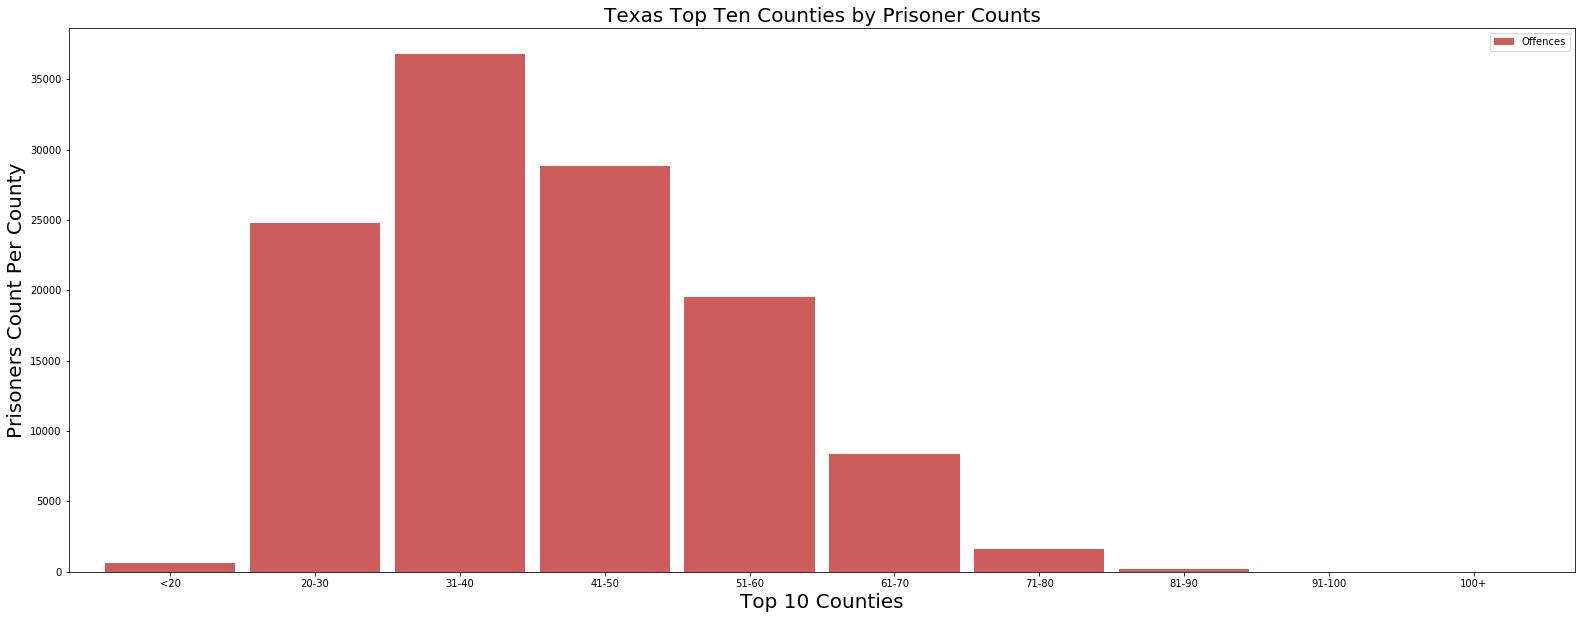

In [94]:
# Plotting Top 10 Counties in Texas prison system
qcklk_cnty_cnt.plot(kind='bar', width = .9, color= 'indianred', figsize=(27,10))
plt.xlabel("Top 10 Counties", fontsize=20)
plt.ylabel("Prisoners Count Per County", fontsize=20)
plt.xticks(rotation=0, horizontalalignment='center')
plt.title("Texas Top Ten Counties by Prisoner Counts", fontsize=20)
#plt.savefig("./output_data/Texas_Top_10_Counties_By_Prisoner_Counts.png")
plt.show()

### Top 10 Offences by Texas Prisoners

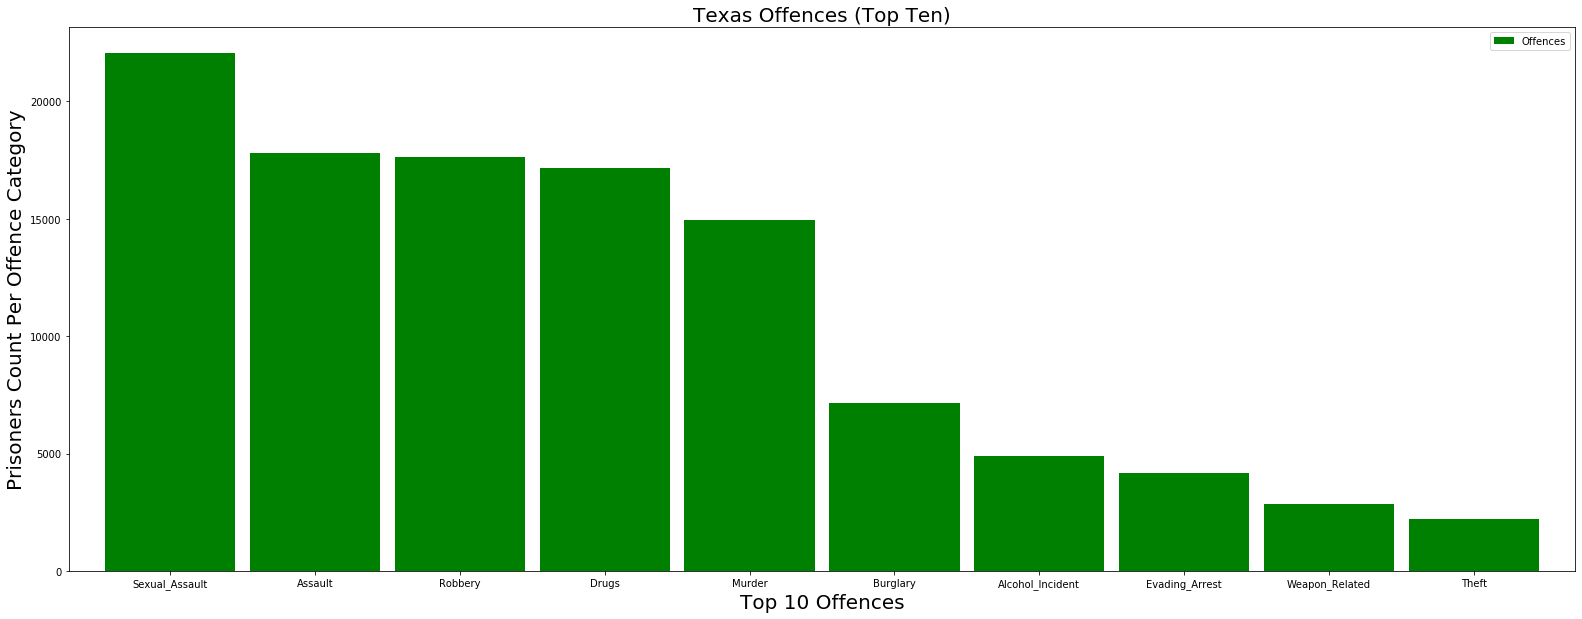

In [95]:
# Plotting Top 10 offences in Texas prison system
qcklk_crime_cnt.plot(kind='bar', width = .9, color= 'g', figsize=(27,10))
plt.xlabel("Top 10 Offences", fontsize=20)
plt.ylabel("Prisoners Count Per Offence Category", fontsize=20)
plt.xticks(rotation=0, horizontalalignment='center')
plt.title("Texas Offences (Top Ten)", fontsize=20)
#plt.savefig("./output_data/Texas_Top_10_Offences_By_Offence_Counts.png")
plt.show()

### Counts of Texas Prisoners by Age Ranges in Top 10 Counties

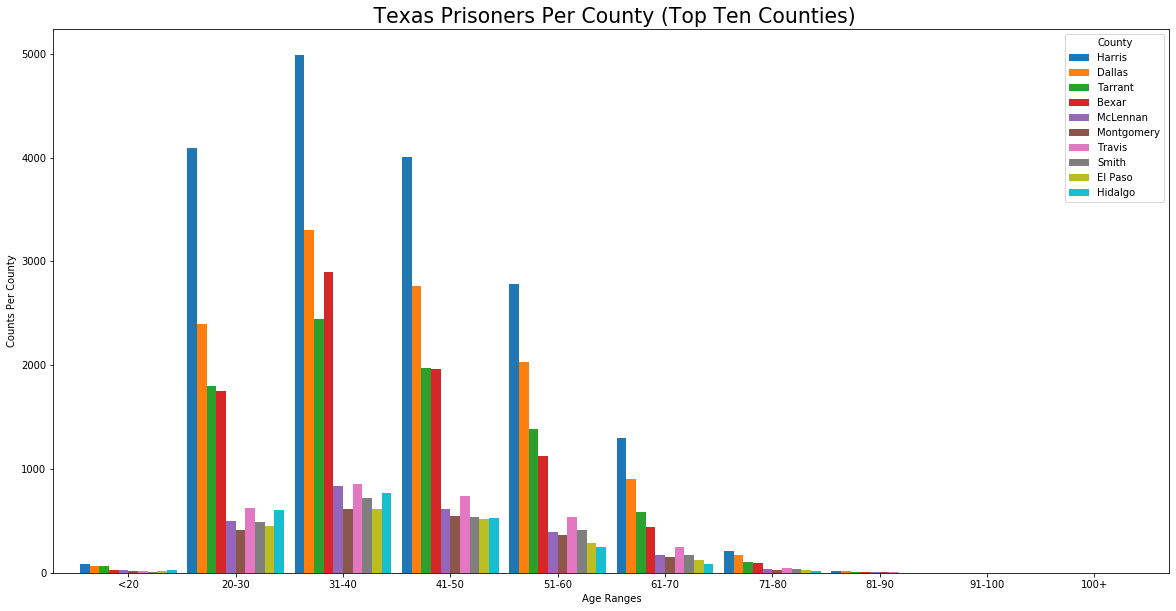

In [96]:
# Plotting Texas prisoners by offence count in Top 10 Counties
ag_cnt_unstk_sortd_df.plot(kind='bar', width = 0.9, figsize=(20,10))
plt.xlabel("Age Ranges")
plt.ylabel("Counts Per County")
plt.xticks(rotation=0, horizontalalignment='center')
plt.rcParams['font.size'] = '17'
plt.title(" Texas Prisoners Per County (Top Ten Counties)")
#plt.savefig("./output_data/Texas_Crimes_By_Age_Bracket_By_Counties.png")
plt.show()

### Total Offence Counts by Age Ranges of Texas Prisoners

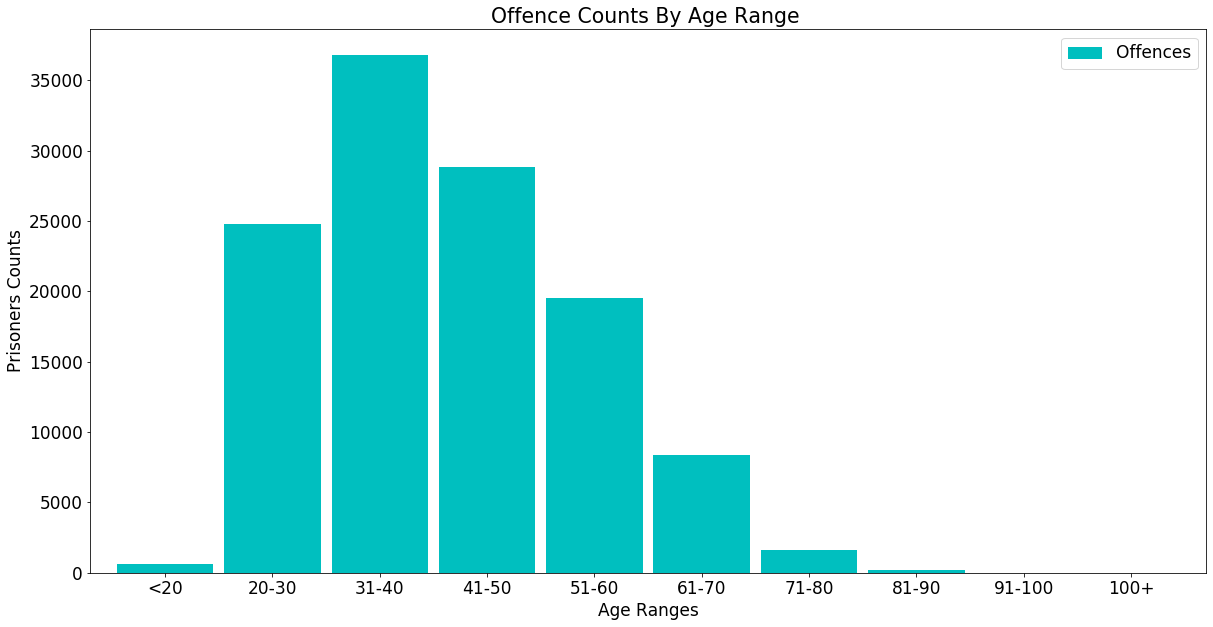

In [97]:
# Plotting Offences by age brackets in the Texas Prison system
qcklk_cnty_cnt.plot(kind='bar', width = .9, color= 'c', figsize=(20,10))
plt.xlabel("Age Ranges", fontsize=17)
plt.ylabel("Prisoners Counts", fontsize=17)
plt.xticks(rotation=0, horizontalalignment='center')
plt.title("Offence Counts By Age Range ")
#plt.savefig("./output_data/Texas_Total_Offences_By_Age_Bracket.png")
plt.show()

### Top 10 Offences by Age Ranges of Texas Prisoners

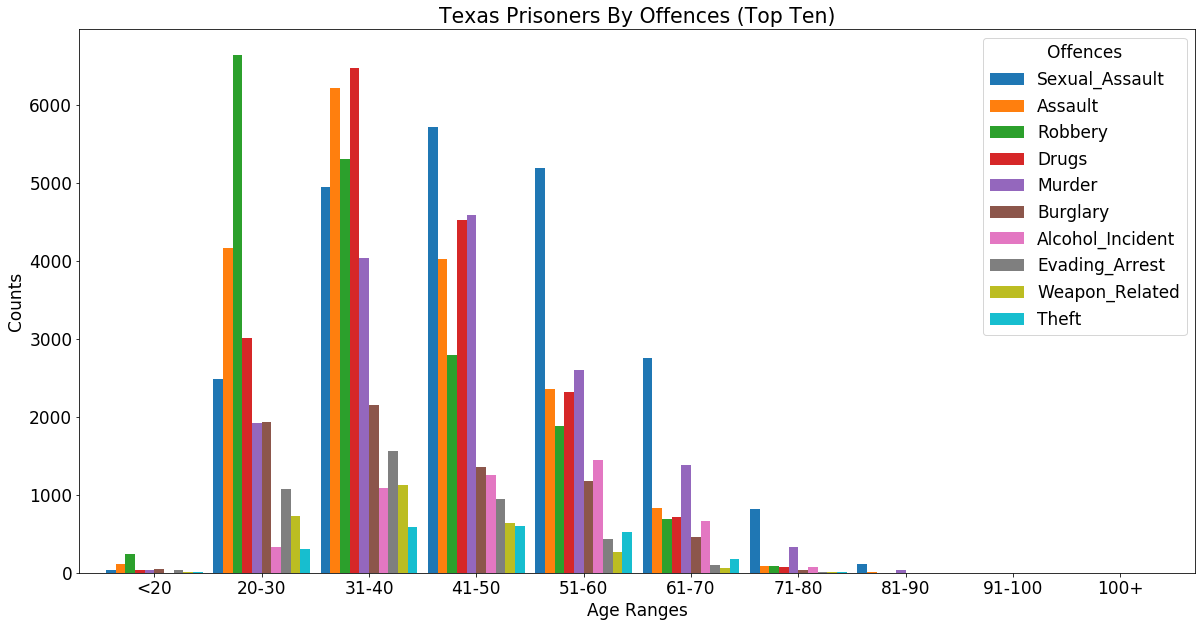

In [98]:
# Plotting Top 10 Offences by age ranges in the Texas Prison System
ag_crime_unstk_sortd_df.plot(kind='bar', width = 0.9, align='center', figsize=(20,10))
plt.xlabel("Age Ranges")
plt.ylabel("Counts")
plt.xticks(rotation=0, horizontalalignment='center')
plt.title("Texas Prisoners By Offences (Top Ten)")
plt.rcParams['font.size'] = '17'
#plt.savefig("./output_data/Texas_Crimes_By_Age_Bracket_By_Offence_Categories.png")
plt.show()

### Top 10 Offences by spread in Top 10 Texas Counties

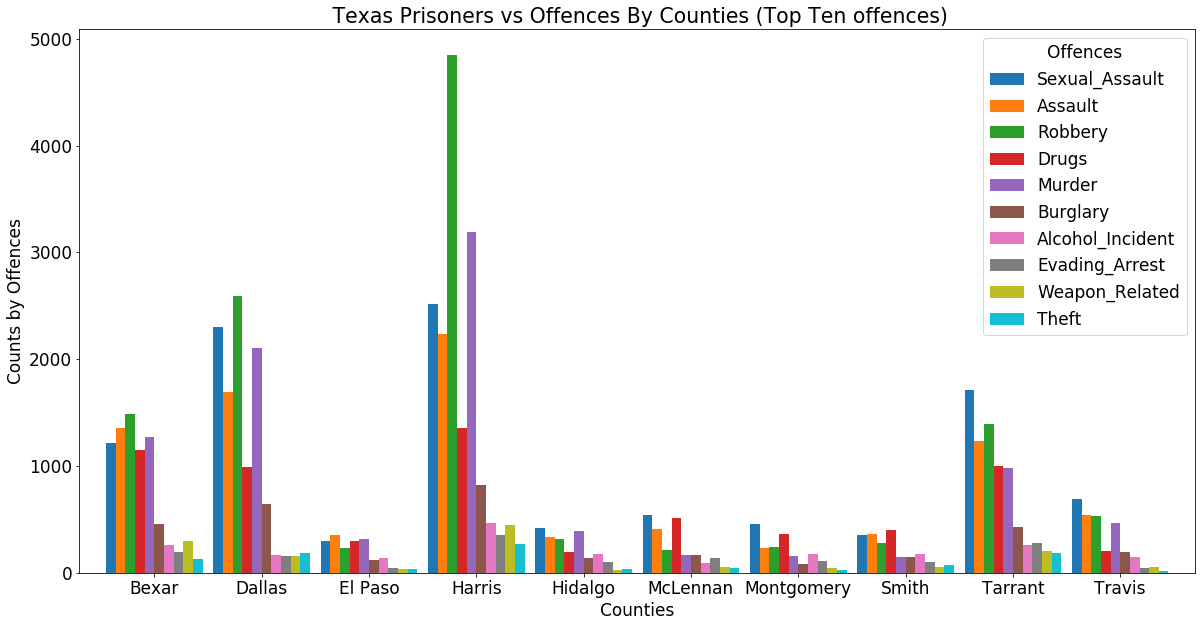

In [99]:
# Plotting spread of Top 10 Offences in Top 10 Counties in the Texas Prison System
results_chck_sortd.plot(kind='bar', width = .9, figsize=(20,10))
plt.xlabel("Counties")
plt.ylabel("Counts by Offences")
plt.xticks(rotation=0, horizontalalignment='center')
plt.rcParams['font.size'] = '17'
plt.title(" Texas Prisoners vs Offences By Counties (Top Ten offences)")
#plt.savefig("./output_data/Texas_Prisoner_Population_By_Offences_Per_Top10_Counties.png")
plt.show()

### Texas Prisoners By Gender and Offence Categories

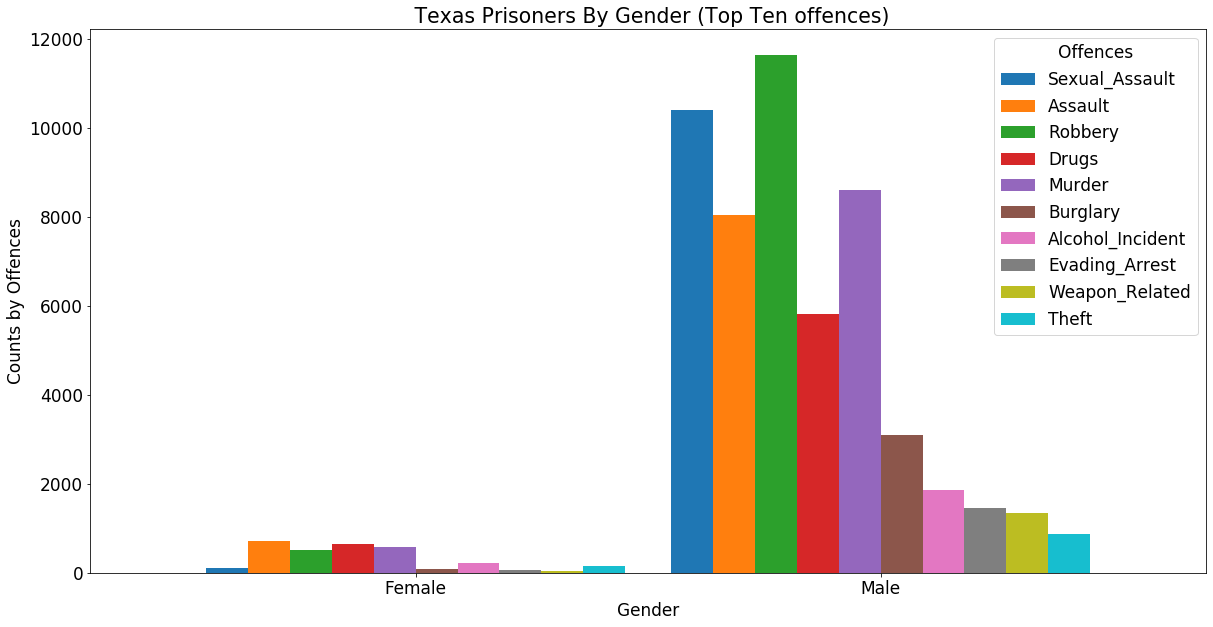

In [100]:
results_chck_1_sortd.plot(kind='bar', width = .9, figsize=(20,10))
plt.xlabel("Gender")
plt.ylabel("Counts by Offences")
plt.xticks(rotation=0, horizontalalignment='center')
plt.rcParams['font.size'] = '17'
plt.title(" Texas Prisoners By Gender (Top Ten offences)")
#plt.savefig("./output_data/Texas_Crimes_By_Gender_Per_Offences.png")
plt.show()

### Texas Male Prisoners Age Categories vs Offense counts by Counties

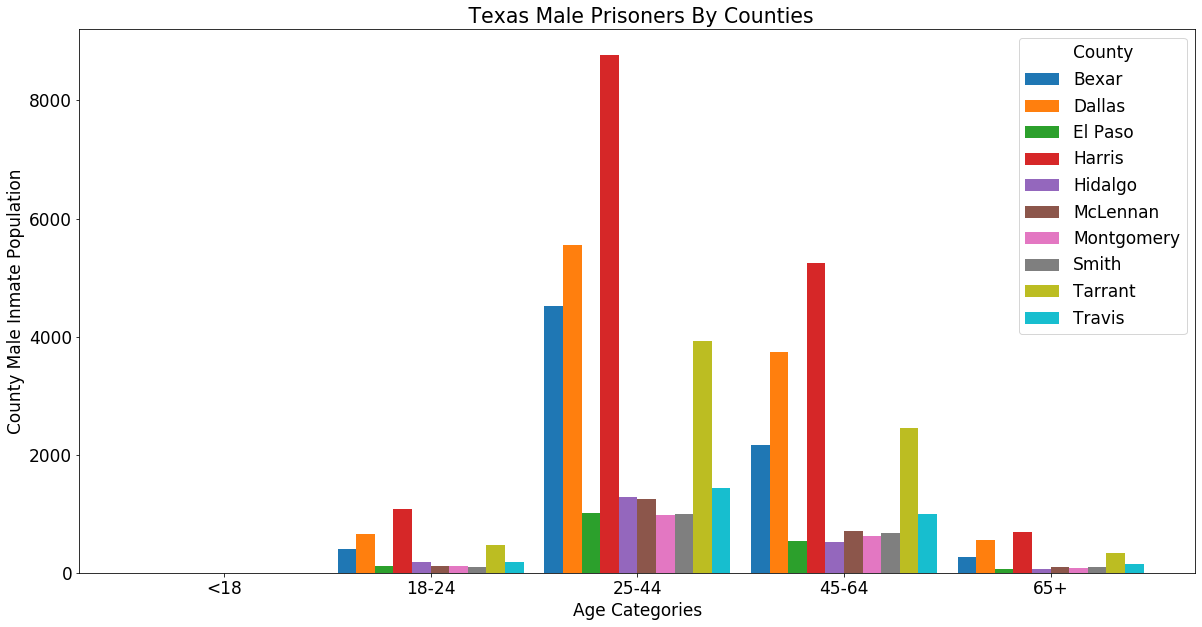

In [101]:
results_gend_chck_1.plot(kind='bar', width = .9, figsize=(20,10))
plt.xlabel("Age Categories")
plt.ylabel("County Male Inmate Population")
plt.xticks(rotation=0, horizontalalignment='center')
plt.rcParams['font.size'] = '17'
plt.title(" Texas Male Prisoners By Counties")
#plt.savefig("./output_data/Texas_Crimes_By_Gender_Per_Offences.png")
plt.show()

### Texas Male Prisoners Age Categories vs Offence counts 

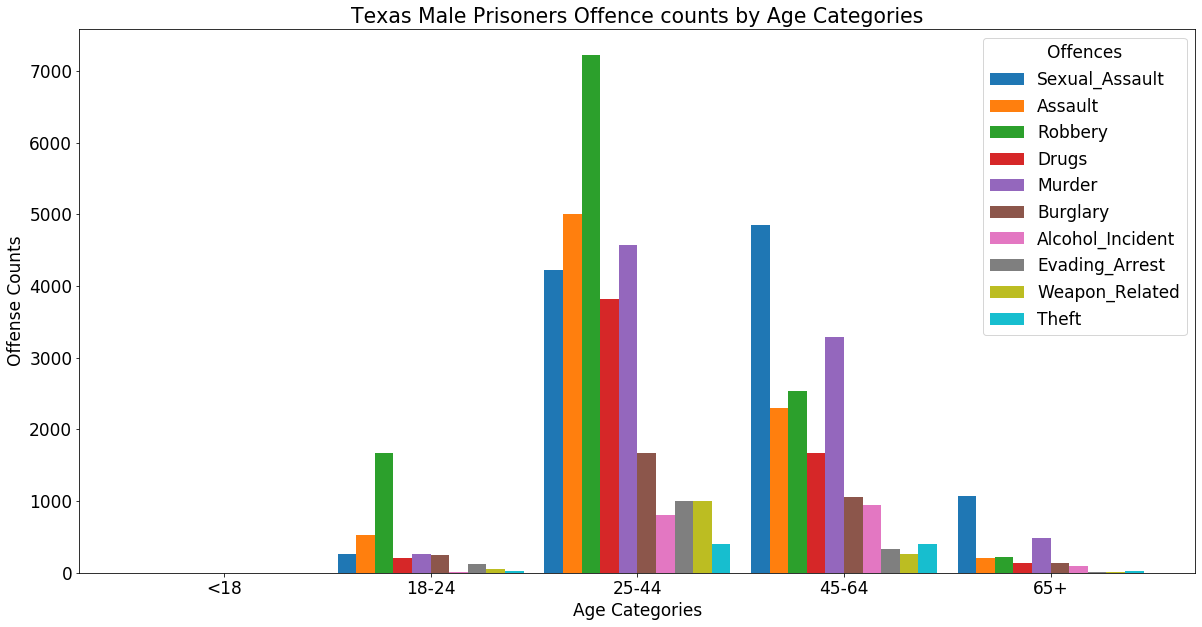

In [102]:
results_chck_agegp_sortd.plot(kind='bar', width = .9, figsize=(20,10))
plt.xlabel("Age Categories")
plt.ylabel("Offense Counts")
plt.xticks(rotation=0, horizontalalignment='center')
plt.rcParams['font.size'] = '17'
plt.title("Texas Male Prisoners Offence counts by Age Categories")
#plt.savefig("./output_data/Texas_Crimes_By_Offense_Counts.png")
plt.show()

### Texas Prisoner Population Ratio to County Population by Age Groups (Top Ten Counties)

#### Texas Prisoners By Percentage of County Population

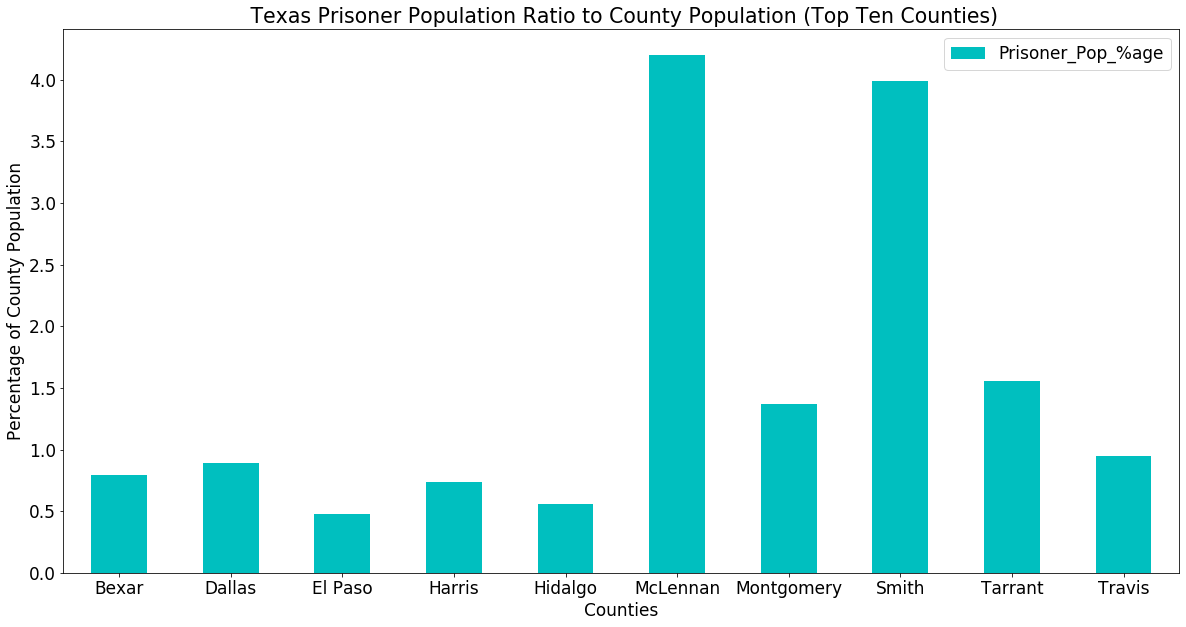

In [103]:
# Plooting Top 10 counties inmate population as ratio of county population
forplot_cnty_perc.plot.bar(rot=0, color='c', figsize=(20,10))
plt.xlabel("Counties")
plt.ylabel("Percentage of County Population")
plt.xticks(rotation=0, horizontalalignment='center')
plt.rcParams['font.size'] = '17'
plt.title(" Texas Prisoner Population Ratio to County Population (Top Ten Counties)")
plt.legend()
#plt.savefig("./output_data/Texas_Prisoner_Population_to_County_Population.png")
plt.show()

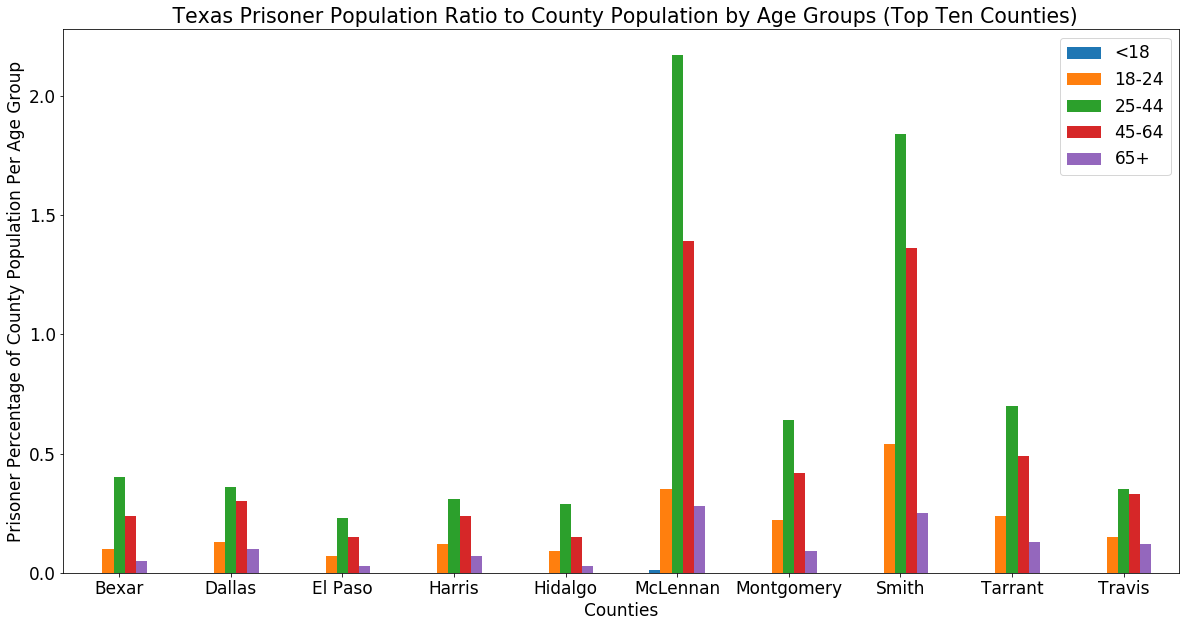

In [104]:
# Plotting Texas prisoners population as a ratio of county population by age groups
pop_jemthsp_merged_3.plot.bar(rot=0, figsize=(20,10))
plt.xlabel("Counties")
plt.ylabel("Prisoner Percentage of County Population Per Age Group")
plt.xticks(rotation=0, horizontalalignment='center')
plt.rcParams['font.size'] = '17'
plt.legend(['<18', '18-24', '25-44', '45-64', '65+'])
plt.title(" Texas Prisoner Population Ratio to County Population by Age Groups (Top Ten Counties)")
#plt.savefig("./output_data/Texas_Prisoner_Population_to_County_Population_By_Age_Brackets.png")
plt.show()

### Texas County Population for Top 10 Counties by Age Groups

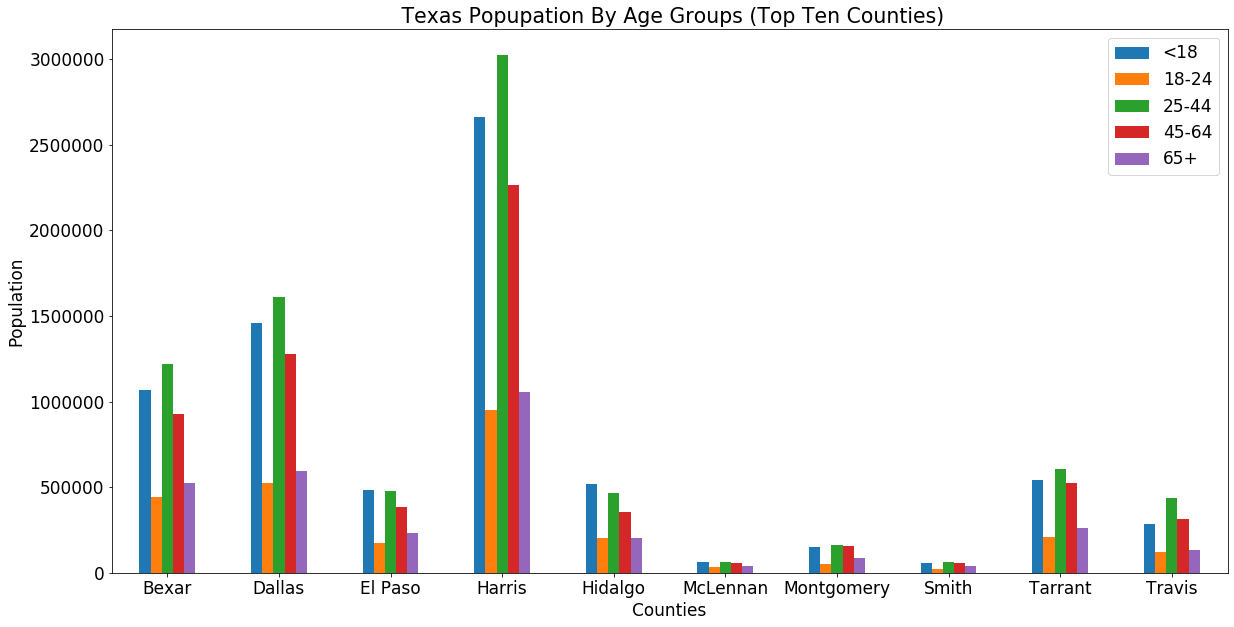

In [105]:
# Plotting Top 10 Counties population by each age group
pop_jemthsp_cnty_3.plot.bar(rot=0, figsize=(20,10))
plt.xlabel("Counties")
plt.ylabel("Population")
plt.xticks(rotation=0, horizontalalignment='center')
plt.rcParams['font.size'] = '17'
plt.legend(['<18', '18-24', '25-44', '45-64', '65+'])
plt.title(" Texas Popupation By Age Groups (Top Ten Counties)")
#plt.savefig("./output_data/Texas_Population_By_Age_Bracket_(2020).png")
plt.show()